# Classify drugs based on their biological activity
This notebook uses a tabular dataset with 25_000 entries, 900 features and 200 labels. It also has a supplemental 400 labels that are used in training but not in testing. The problem is multilabel classification. We first perfom dimensionality reduction via an autoencoder then train a multilayer neural network

## Table of Contents
* [Introduction](#introduction)
* [Data Exploration](#data-exploration)
* [Feature Engineering](#feature-engineering)
    * [Autoencoder](#autoencoder)
* [Model Training](#model-training)
* [Evaluation](#evaluation)
* [Conclusion](#conclusion)

<a id="introduction"></a>
## Introduction
The notebook was written for <a href="https://www.kaggle.com/competitions/lish-moa">Mechanisms of Action (MoA) Prediction</a> on Kaggle, as a late submission. It classifies drugs for their action on human cells, based on 3 categorical features (type - control or real drug, time of administration - 24/48/72h and dosage - d1/d2), about 800 gene actions and 100 cell actions - obtained from comparing genomic and cell action databases with results from the lab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install iterative-stratification
!pip install skorch


In [ ]:
# Standard library imports
import os
import random
from collections import Counter
from typing import Tuple

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
import itertools
import textwrap

# Scikit-learn imports
from sklearn.decomposition import PCA
from sklearn.metrics import log_loss, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, QuantileTransformer, OneHotEncoder
from sklearn.utils import class_weight
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from skorch import NeuralNetClassifier

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.parametrizations import weight_norm
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Set random seeds for reproducibility
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

<a id="data-exploration"></a>
## Data exploration

In [ ]:
data_path = "/content/drive/MyDrive/Colab/moa/"
output_path = data_path

 train_targets_scored contains the labels that are used in testing and train_targets_nonscored contains suplemental labels that are not used in testing, but provide a better classification performance. The datasets are indexed by a column named sig_id that provides a unique key which I use to join them, similar to sql tables. train_drug is just a table of wich drug was used in each sig_id experiment. The values are not unique, each drug beeing potentialy used in multiple tests.

In [ ]:
train_features = pd.read_csv(data_path + "train_features.csv")
test_features = pd.read_csv(data_path + "test_features.csv")
sample_submission = pd.read_csv(data_path + "sample_submission.csv")
train_targets_nonscored = pd.read_csv(data_path + "train_targets_nonscored.csv")
train_targets_scored = pd.read_csv(data_path + "train_targets_scored.csv")
train_drug = pd.read_csv(data_path + "train_drug.csv")

In [ ]:
print(train_features.shape)
print(test_features.shape)
print(sample_submission.shape)
print(train_targets_nonscored.shape)
print(train_targets_scored.shape)
print(train_drug.shape)

(23814, 876)
(3982, 876)
(3982, 207)
(23814, 403)
(23814, 207)
(23814, 2)


trt_cp represens the real drug beeing used in testing and ctl_vehicle represents the control substance (with no real action). g- represents gene actions (approximately 800) and c- represent cells actions (100).

In [ ]:
train_features.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


### The labels are very sparse

In [ ]:
train_targets_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_targets_nonscored.head()

,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


verify that train_targets_scored (that are ued at training and testing) and train_targets_nonscored (that are used just for training) are disjoint sets

In [ ]:
#this should be disjoint sets
train_targets_nonscored_columns_set = set(train_targets_nonscored.columns.tolist())
train_targets_scored_columns_set = set(train_targets_scored.columns.tolist())
common_targets_scored_nonscored = train_targets_scored_columns_set.intersection(train_targets_nonscored_columns_set)
print(common_targets_scored_nonscored)

{'sig_id'}


I generally tend to aggregate the tables in one big dataframe for better processing. Here this join signifies that both categories of targets will be used at training

In [ ]:
train_targets_all = pd.merge(train_targets_scored, train_targets_nonscored, on='sig_id', how='inner')

In [ ]:
print(train_targets_all.shape)
train_targets_all.head()

(23814, 609)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
dataset = pd.merge(train_features, train_targets_all, on='sig_id', how='inner').reset_index(drop=True)

print(dataset.shape)
dataset.tail()

(23814, 1484)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
23809,id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,trt_cp,24,D2,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,trt_cp,24,D1,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,...,0,0,0,0,0,0,0,0,0,0
23813,id_ffffdd77b,trt_cp,72,D1,-0.8598,1.0240,-0.1361,0.7952,-0.3611,-3.6750,...,0,0,0,0,0,0,0,0,0,0


### verify if there are any missing values (there are not)

In [ ]:
dataset.fillna(np.nan)
df_missing_values = dataset.isna().sum()
print([s for s in df_missing_values.index if df_missing_values[s] > 0])

[]


In [ ]:
train_len = dataset.shape[0] # length of training samples, as oposed to testing samples
print(train_len)
dataset = pd.concat([dataset, test_features], axis=0).reset_index(drop=True)
print(dataset.shape)
print(dataset.tail()) # here are some NaNs
print(dataset[:train_len]) #verify that train_len is ok

23814
(27796, 1484)
             sig_id cp_type  cp_time cp_dose     g-0     g-1     g-2     g-3  \
27791  id_ff7004b87  trt_cp       24      D1  0.4571 -0.5743  3.3930 -0.6202   
27792  id_ff925dd0d  trt_cp       24      D1 -0.5885 -0.2548  2.5850  0.3456   
27793  id_ffb710450  trt_cp       72      D1 -0.3985 -0.1554  0.2677 -0.6813   
27794  id_ffbb869f2  trt_cp       48      D2 -1.0960 -1.7750 -0.3977  1.0160   
27795  id_ffd5800b6  trt_cp       72      D1 -0.5174  0.2953  0.3286 -0.0428   

          g-4     g-5  ...  ve-cadherin_antagonist  \
27791  0.8557  1.6240  ...                     NaN   
27792  0.4401  0.3107  ...                     NaN   
27793  0.0152  0.4791  ...                     NaN   
27794 -1.3350 -0.2207  ...                     NaN   
27795 -0.0800  0.8702  ...                     NaN   

       vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
27791                                        NaN                   NaN   
27792                     

In [ ]:
train_features.dtypes

,0
sig_id,object
cp_type,object
cp_time,int64
cp_dose,object
g-0,float64
...,...
c-95,float64
c-96,float64
c-97,float64
c-98,float64


break features into classes

In [ ]:
train_features_metadata_cols = [ 'cp_type', 'cp_time', 'cp_dose']
g_cols = [col for col in dataset.columns if col.startswith('g-')]
c_cols = [col for col in dataset.columns if col.startswith('c-')]
print(len(g_cols), len(c_cols))

772 100


### the gene expression (g-) and cell viability (c-) features are pre-processed data  already normalized and clipped to a range of approximately [-10, 10], so no point in detecting outliers


In [ ]:
print(train_features[g_cols].describe())
print(train_features[c_cols].describe())

                g-0           g-1           g-2           g-3           g-4  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean       0.248366     -0.095684      0.152253      0.081971      0.057347   
std        1.393399      0.812363      1.035731      0.950012      1.032091   
min       -5.513000     -5.737000     -9.104000     -5.998000     -6.369000   
25%       -0.473075     -0.562200     -0.437750     -0.429575     -0.470925   
50%       -0.008850     -0.046600      0.075200      0.008050     -0.026900   
75%        0.525700      0.403075      0.663925      0.463400      0.465375   
max       10.000000      5.039000      8.257000     10.000000     10.000000   

                g-5           g-6           g-7           g-8           g-9  \
count  23814.000000  23814.000000  23814.000000  23814.000000  23814.000000   
mean      -0.138836      0.035961     -0.202651     -0.190083      0.119905   
std        1.179388      0.882395      1.125494    

### value counts for categorical variables

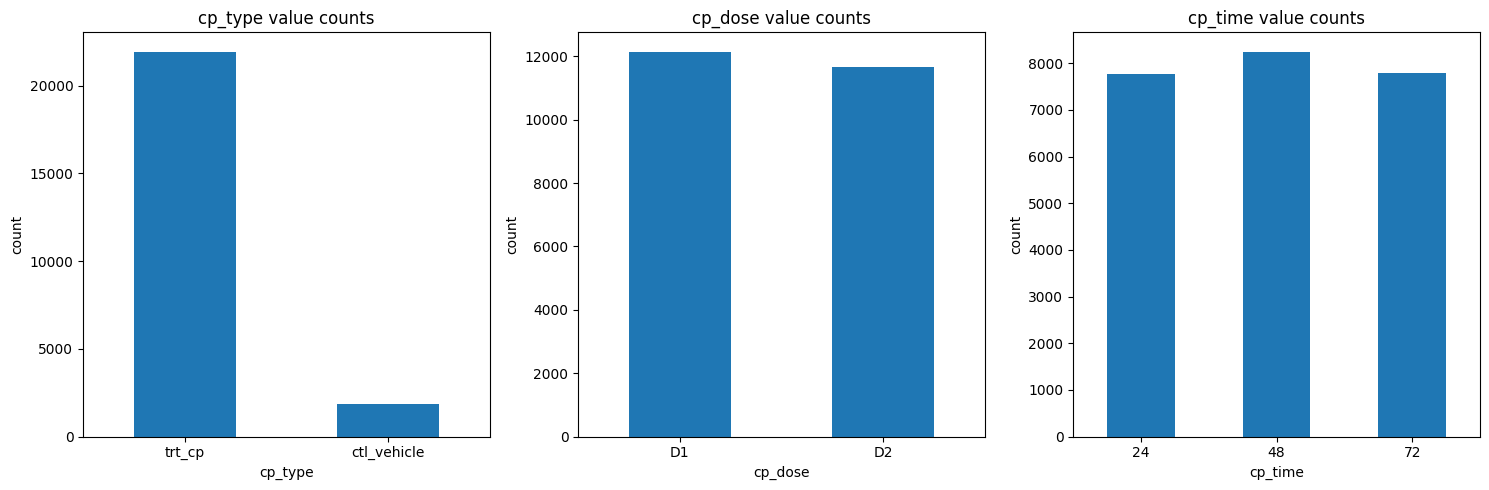

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

train_features['cp_type'].value_counts().plot(kind='bar', rot=0, ax = axes[0])
axes[0].set_title('cp_type value counts')
axes[0].set_ylabel('count')
axes[0].set_xlabel('cp_type')

train_features['cp_dose'].value_counts().plot(kind='bar', rot=0, ax=axes[1])
axes[1].set_title('cp_dose value counts')
axes[1].set_ylabel('count')
axes[1].set_xlabel('cp_dose')

train_features['cp_time'].value_counts().loc[[24, 48, 72]].plot(kind='bar', rot=0, ax=axes[2])
axes[2].set_title('cp_time value counts')
axes[2].set_ylabel('count')
axes[2].set_xlabel('cp_time')

plt.tight_layout()
plt.show()

### Density plots from a random sample of genes

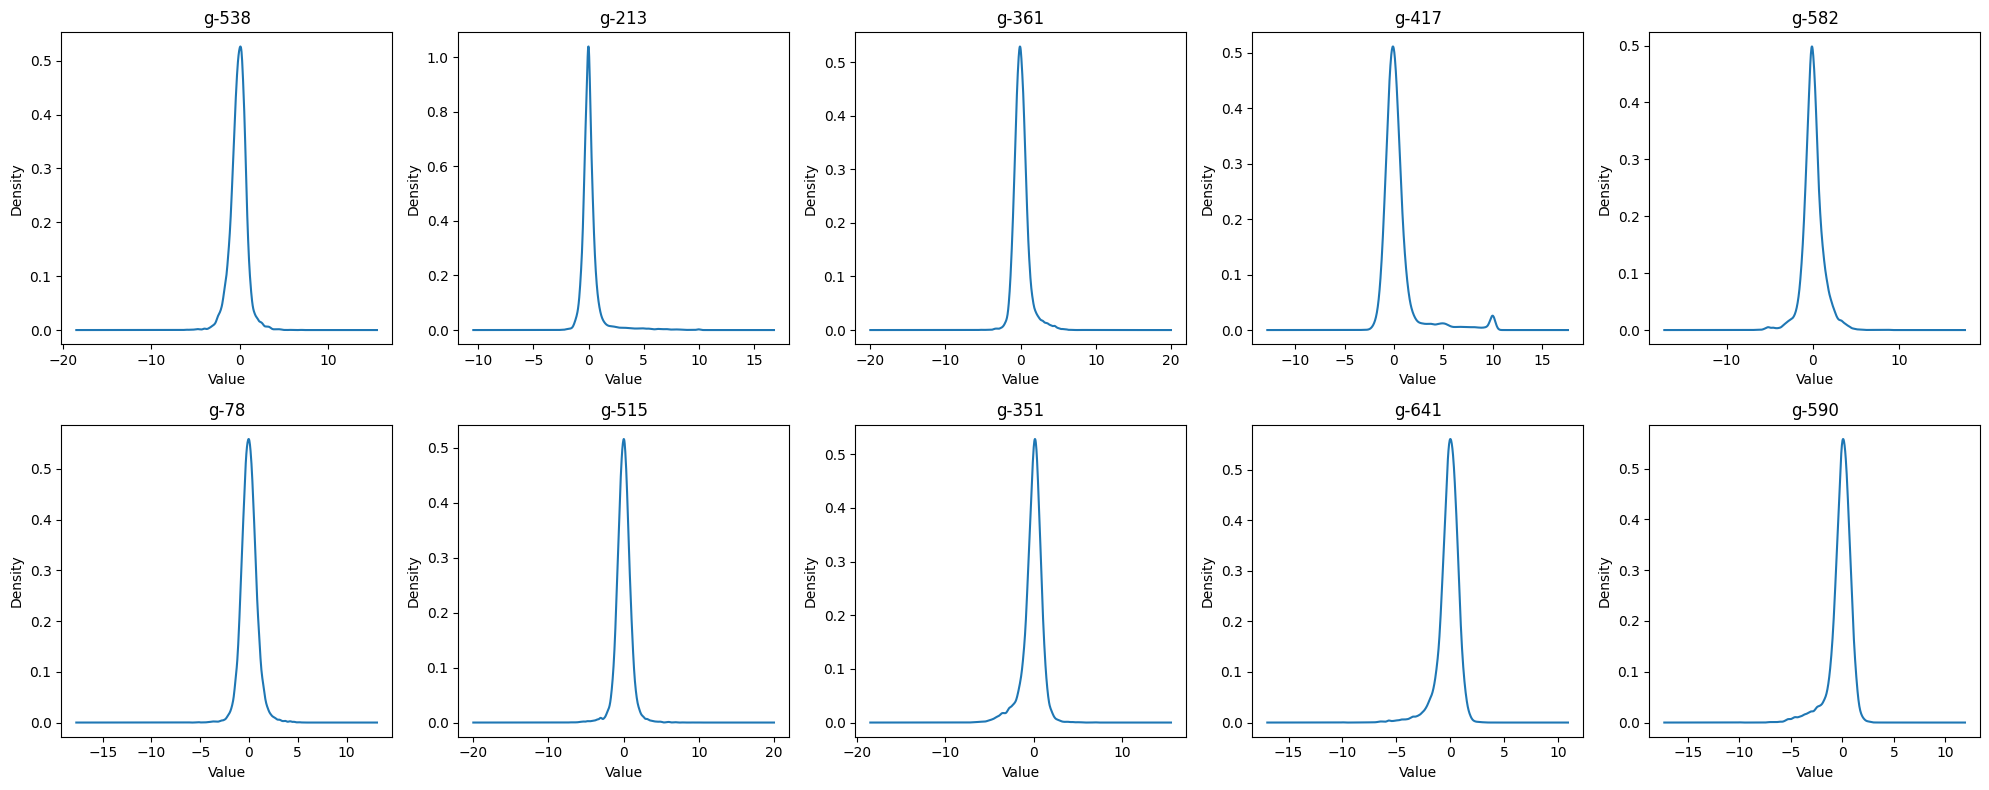

In [ ]:
random_sample_cols = pd.Series(g_cols).sample(10, random_state=42).tolist()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(random_sample_cols):
    train_features[col].plot.kde(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()

### Density plots from a random sample of cells

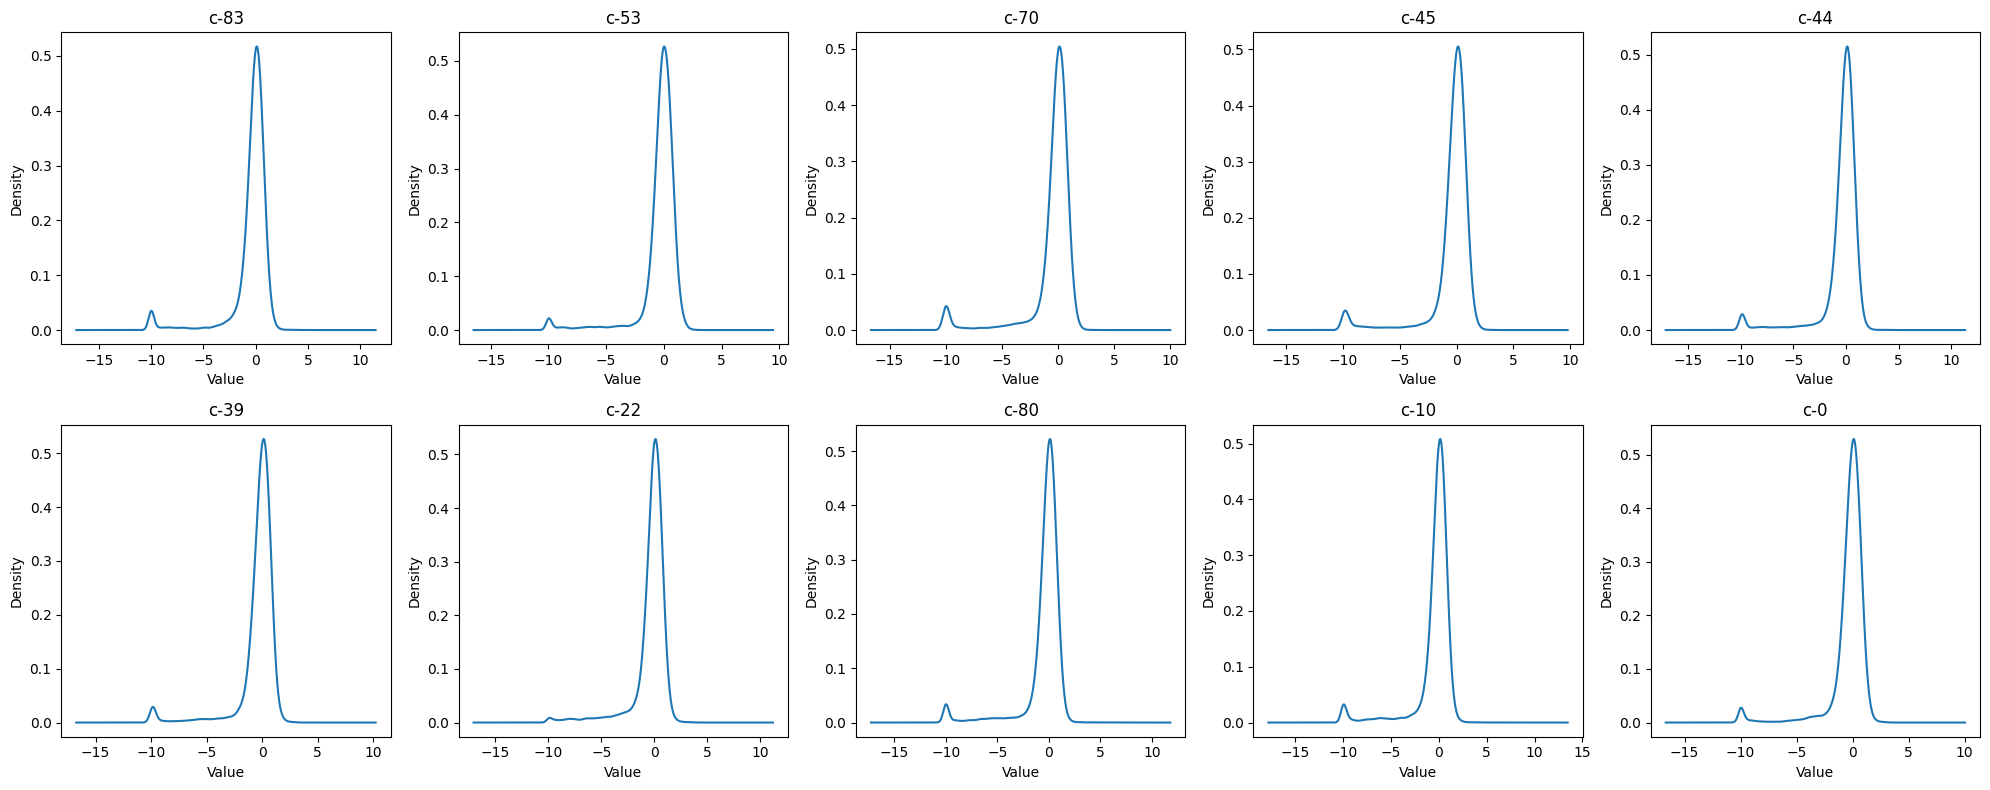

In [ ]:
random_sample_cols = pd.Series(c_cols).sample(10, random_state=42).tolist()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, col in enumerate(random_sample_cols):
    train_features[col].plot.kde(ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
plt.tight_layout()
plt.show()

In [ ]:
corr_cells = train_features[c_cols].corr()
corr_genes = train_features[g_cols].corr()

treshold=0.8 # treshold of correlation, because of the high number of features
mask_c = np.abs(corr_cells) <= treshold
mask_g = np.abs(corr_genes) <= treshold

masked_corr_cells = corr_cells.where(~mask_c)
masked_corr_genes = corr_genes.where(~mask_g)

### we observe that cell features are highly corellated

<Axes: >

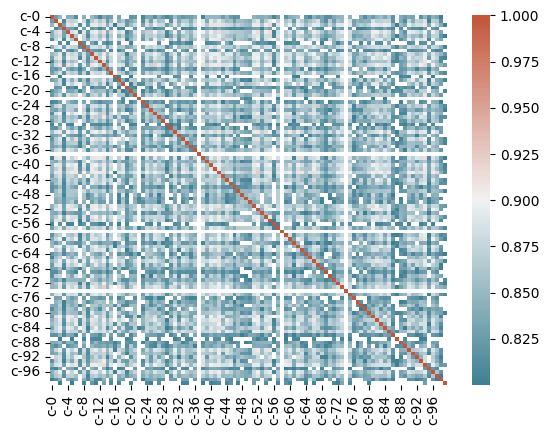

In [ ]:
sns.heatmap(masked_corr_cells, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### the gene features are not correlated

<Axes: >

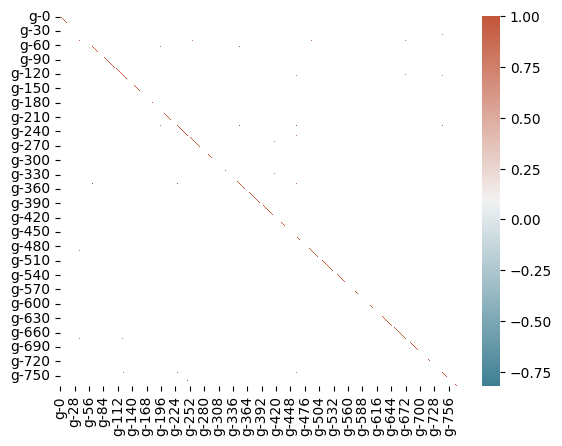

In [ ]:
sns.heatmap(masked_corr_genes, cmap=sns.diverging_palette(220, 20, as_cmap=True))

### there is some correlation for a small subset of cross features (genes vs cells)

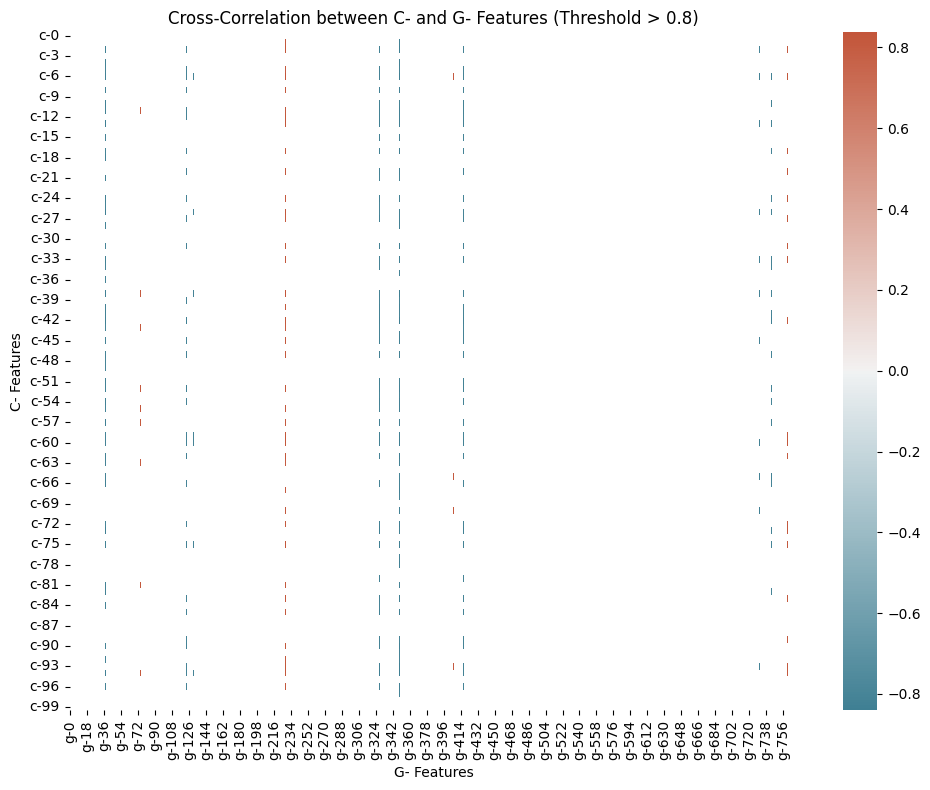

In [ ]:
# Calculate the cross-correlation matrix between c_cols and g_cols
# Calculate the correlation of the combined dataframe and then select the cross-correlation part
combined_features = pd.concat([train_features[c_cols], train_features[g_cols]], axis=1)
full_corr_matrix = combined_features.corr()

# Extract the cross-correlation part
cross_corr_matrix = full_corr_matrix.loc[c_cols, g_cols]

# Apply the mask with a threshold of 0.8
threshold_cross = 0.8
mask_cross = np.abs(cross_corr_matrix) <= threshold_cross
masked_cross_corr_matrix = cross_corr_matrix.where(~mask_cross)

# Display the heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(masked_cross_corr_matrix, cmap=sns.diverging_palette(220, 20, as_cmap=True), center=0)
plt.title('Cross-Correlation between C- and G- Features (Threshold > 0.8)')
plt.xlabel('G- Features')
plt.ylabel('C- Features')
plt.tight_layout()
plt.show()

### visualize a sample from the gene pool. no correlation. we observe the cappped values at 10

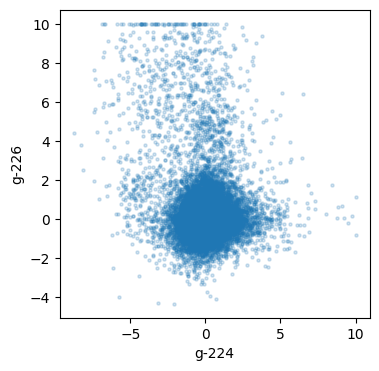

In [ ]:
ax = train_features.plot.scatter(x='g-224', y='g-226',figsize=(4,4), marker='.', alpha=0.2)

### large number of correlated values

In [ ]:
c_corr_matrix = train_features[c_cols].corr()

highly_correlated_c = []

for i in range(len(c_corr_matrix.columns)):
    for j in range(i + 1, len(c_corr_matrix.columns)):
        if abs(c_corr_matrix.iloc[i, j]) > 0.5:
            highly_correlated_c.append((c_corr_matrix.columns[i], c_corr_matrix.columns[j], c_corr_matrix.iloc[i, j]))

print("Highly correlated pairs in c_cols (|correlation| > 0.5):")
# for pair in highly_correlated_c:
    # print(f"{pair[0]} - {pair[1]}: {pair[2]:.4f}")
print(len(highly_correlated_c))

Highly correlated pairs in c_cols (|correlation| > 0.5):
4950


### visualize a sample from the cell pool. strong correlation (linear)

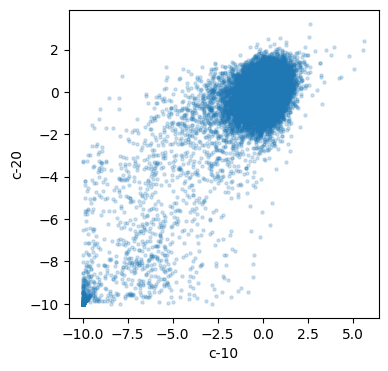

In [ ]:
ax = train_features.plot.scatter(x='c-10', y='c-20',figsize=(4,4), marker='.', alpha=0.2)

aggregate data for display

In [ ]:
gene_stats = train_features[g_cols].agg(['min', 'max', 'mean', 'std']).T
gene_stats = gene_stats.reset_index()
gene_stats = gene_stats.rename(columns={'index': 'features'})

# Reshape the DataFrame to long format
gene_stats_long = gene_stats.melt(id_vars='features', var_name='stat', value_name='values')

# Display the first few rows of the resulting DataFrame
display(gene_stats_long[1000:1010])

,features,stat,values
1000,g-228,max,10.000
1001,g-229,max,10.000
1002,g-230,max,9.818
1003,g-231,max,10.000
1004,g-232,max,10.000
1005,g-233,max,5.476
1006,g-234,max,9.509
1007,g-235,max,10.000
1008,g-236,max,7.878
1009,g-237,max,7.402


### For the gene distributions we observe the capped values at -10 and 10 but also bumps at -6 and 6. The long tails suggests relatively moderate minimum and maximum values for part of the genes. The mean is  a little skewed to the right towards 0.25 but with a balanced spread on either side. The standard deviation shows a right-skewed distribution, peaking around 0.5, suggesting that most genes have moderate variability, with fewer genes exhibiting high variability.

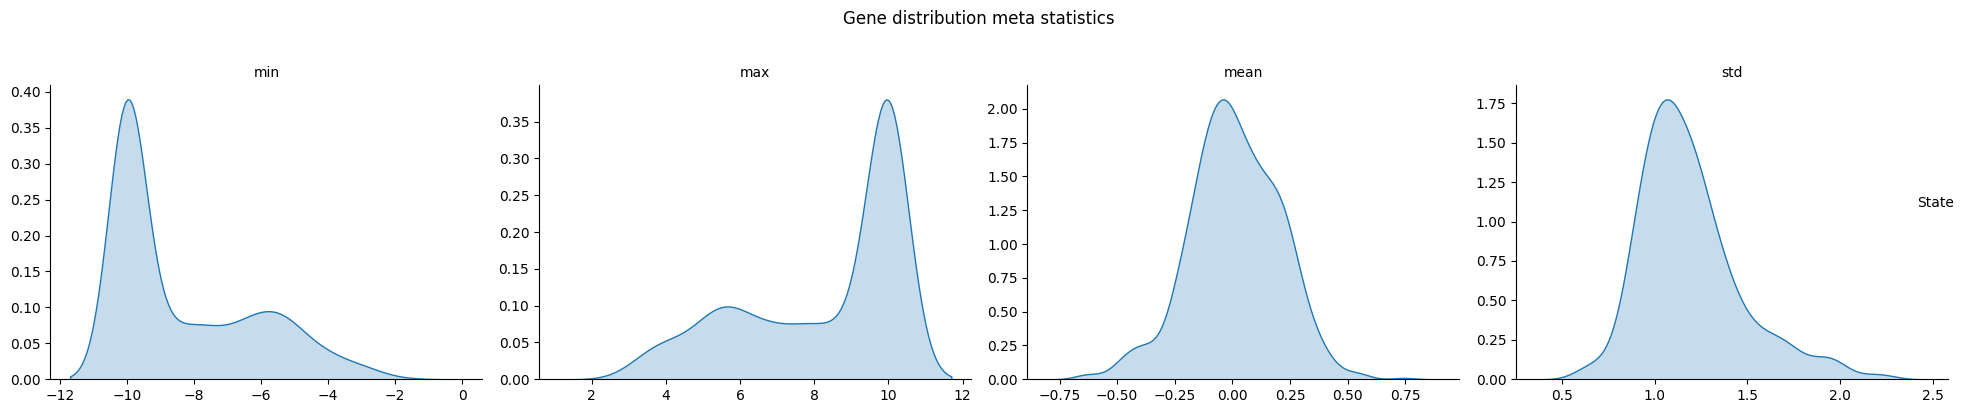

In [ ]:
# Create a FacetGrid for each statistic
g = sns.FacetGrid(gene_stats_long, col="stat", sharex=False, sharey=False, height=4, aspect=1.2)

# Map a density plot onto each facet
g.map(sns.kdeplot, "values", fill=True)

# Add titles and remove legend
g.fig.suptitle("Gene distribution meta statistics", y=1.02)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.add_legend(title="State")

plt.tight_layout()
plt.show()

aggregate data for display

In [ ]:
cell_stats = train_features[c_cols].agg(['min', 'max', 'mean', 'std']).T
cell_stats = cell_stats.reset_index()
cell_stats = cell_stats.rename(columns={'index': 'features'})

# Reshape the DataFrame to long format
cell_stats_long = cell_stats.melt(id_vars='features', var_name='stat', value_name='values')

# Display the first few rows of the resulting DataFrame
display(cell_stats_long.head())

,features,stat,values
0,c-0,min,-10.0
1,c-1,min,-10.0
2,c-2,min,-10.0
3,c-3,min,-10.0
4,c-4,min,-10.0


### For the cells distribution we see that most are capped at -10.The maximum values show a right-skewed distribution, peaking around 4 suggesting that most cells have moderate maximum values, with a tail extending to higher values. The mean values are symmetrically distributed, with a peak near -0.5. The standard deviation is left-skewed, peaking around 2.0, suggesting that most cells have moderate to high variability, with fewer cells showing low variability

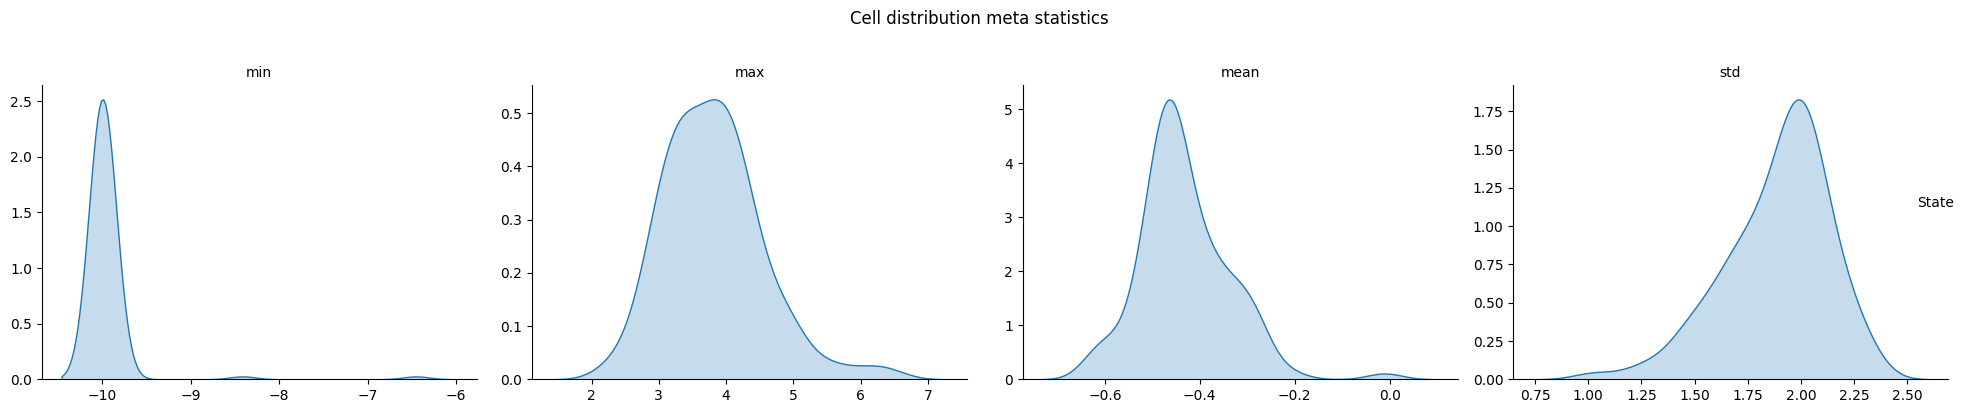

In [ ]:
# Create a FacetGrid for each statistic
g = sns.FacetGrid(cell_stats_long, col="stat", sharex=False, sharey=False, height=4, aspect=1.2)

# Map a density plot onto each facet
g.map(sns.kdeplot, "values", fill=True)

# Add titles and remove legend
g.fig.suptitle("Cell distribution meta statistics", y=1.02)
g.set_titles("{col_name}")
g.set_axis_labels("", "")
g.add_legend(title="State")

plt.tight_layout()
plt.show()

lets look at the negative tails of some cells

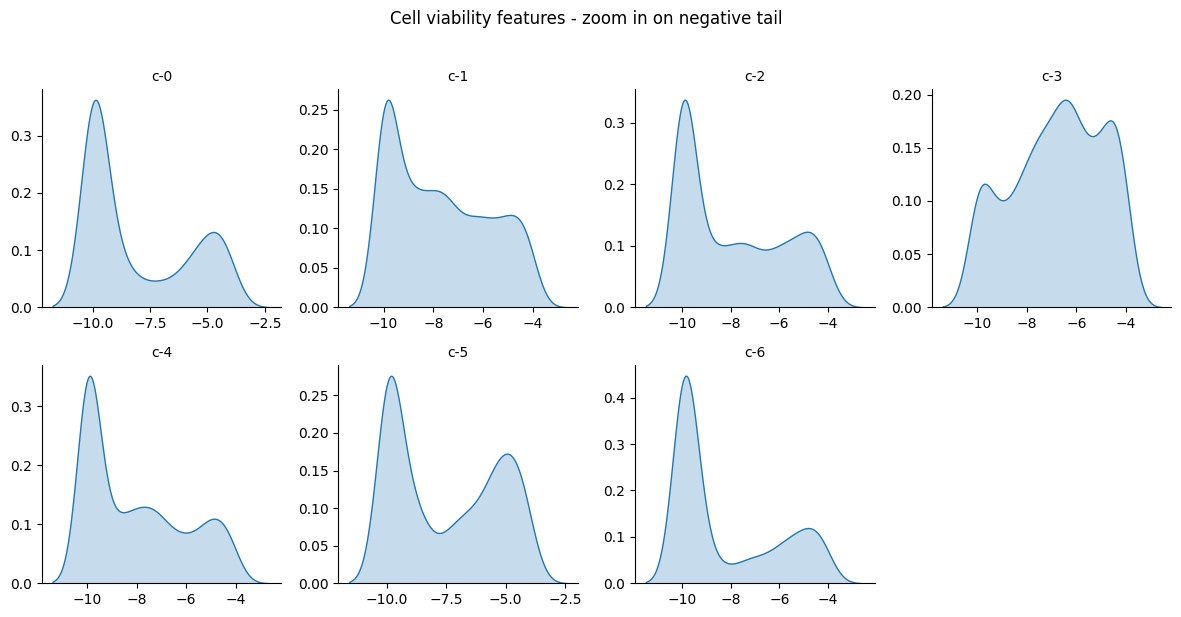

In [ ]:

# Select relevant columns (sig_id and first 7 'c-' columns)
cell_data = train_features[['sig_id'] + c_cols[:7]]

# Melt the DataFrame to long format
cell_data_long = cell_data.melt(id_vars='sig_id', var_name='feature', value_name='value')

# Filter for values less than -4
cell_data_filtered = cell_data_long[cell_data_long['value'] < -4]

# Create density plots for each feature
g = sns.FacetGrid(cell_data_filtered, col="feature", col_wrap=4, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", fill=True)

# Add titles and adjust layout
g.fig.suptitle("Cell viability features - zoom in on negative tail", y=1.02)
g.set_titles("{col_name}")
g.set_axis_labels("", "")

plt.tight_layout()
plt.show()

### The majority of experiments/tests have only 1 activation, and almost 40% have none. This includes the ctl_vehicle data.

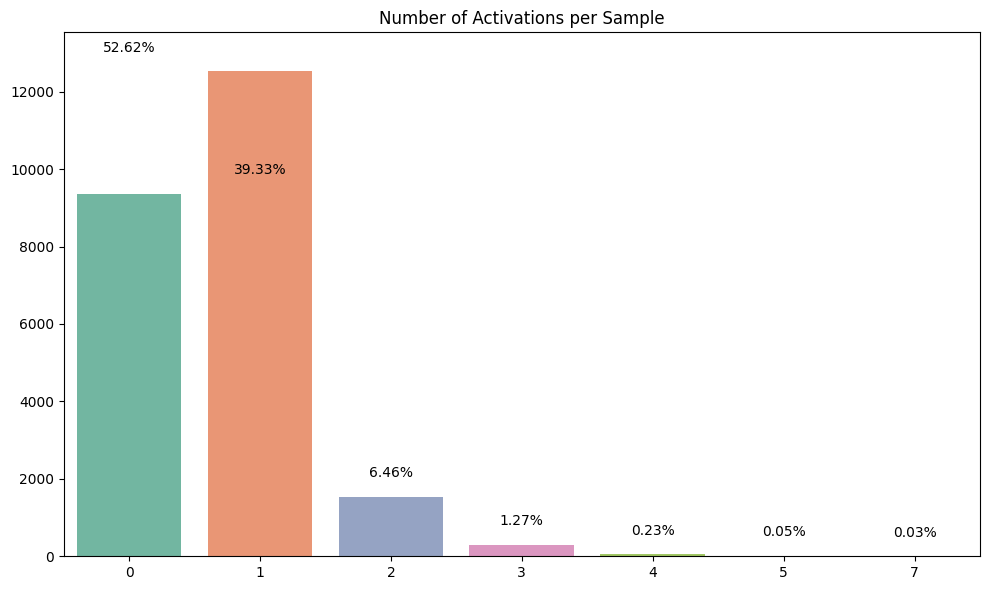

In [ ]:
# Calculate the sum of active MoAs per row
rowstats = train_targets_scored.drop(columns='sig_id').sum(axis=1).reset_index(name='sum')

# Calculate counts and percentages
row_counts = rowstats['sum'].value_counts().reset_index()
row_counts.columns = ['sum', 'n']
row_counts = row_counts.sort_values('sum')
row_counts['total'] = row_counts['n'].sum()
row_counts['perc'] = row_counts['n'] / row_counts['total']

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='sum', y='n', data=row_counts, palette='Set2')

# Add percentage labels on top of the bars
for index, row in row_counts.iterrows():
    ax.text(index, row.n + 500, f'{row.perc:.2%}', color='black', ha="center")

# Set plot title and labels
plt.title("Number of Activations per Sample")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.ylim(0, row_counts['n'].max() + 1000) # Adjust y-lim to accommodate labels
plt.tight_layout()
plt.show()

### For the nonscored data, most have no activation

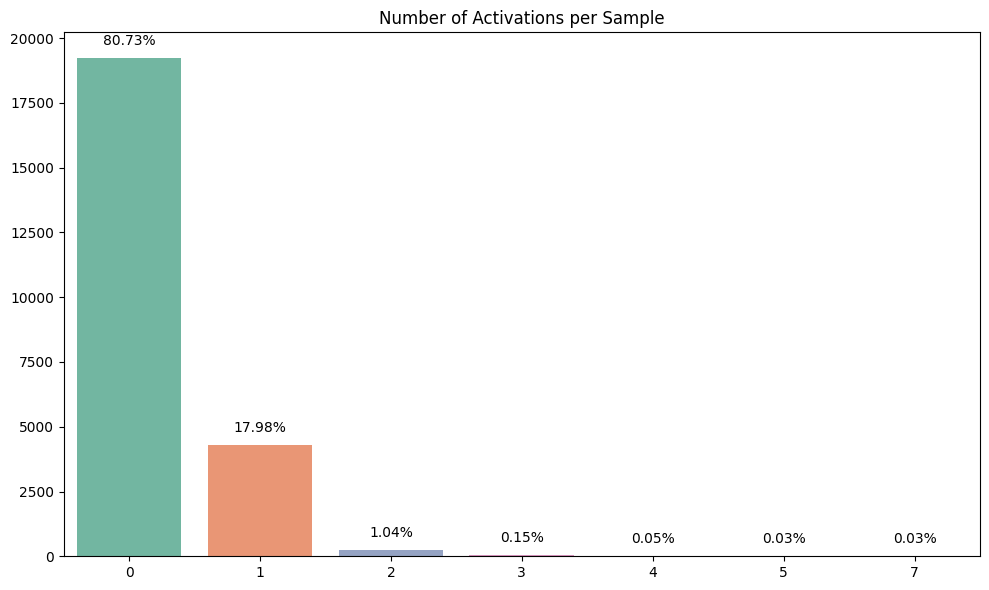

In [ ]:
# Calculate the sum of active MoAs per row
rowstats_nonscored = train_targets_nonscored.drop(columns='sig_id').sum(axis=1).reset_index(name='sum')

# Calculate counts and percentages
row_counts_nonscored = rowstats_nonscored['sum'].value_counts().reset_index()
row_counts_nonscored.columns = ['sum', 'n']
row_counts_nonscored = row_counts_nonscored.sort_values('sum')
row_counts_nonscored['total'] = row_counts_nonscored['n'].sum()
row_counts_nonscored['perc'] = row_counts_nonscored['n'] / row_counts_nonscored['total']

# Create the bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='sum', y='n', data=row_counts_nonscored, palette='Set2')

# Add percentage labels on top of the bars
for index, row in row_counts_nonscored.iterrows():
    ax.text(index, row.n + 500, f'{row.perc:.2%}', color='black', ha="center")

# Set plot title and labels
plt.title("Number of Activations per Sample")
plt.xlabel("")
plt.ylabel("")
plt.xticks(rotation=0)
plt.ylim(0, row_counts_nonscored['n'].max() + 1000) # Adjust y-lim to accommodate labels
plt.tight_layout()
plt.show()

### If we look at the number of activations per label and display the density plot we see a cluster at 40

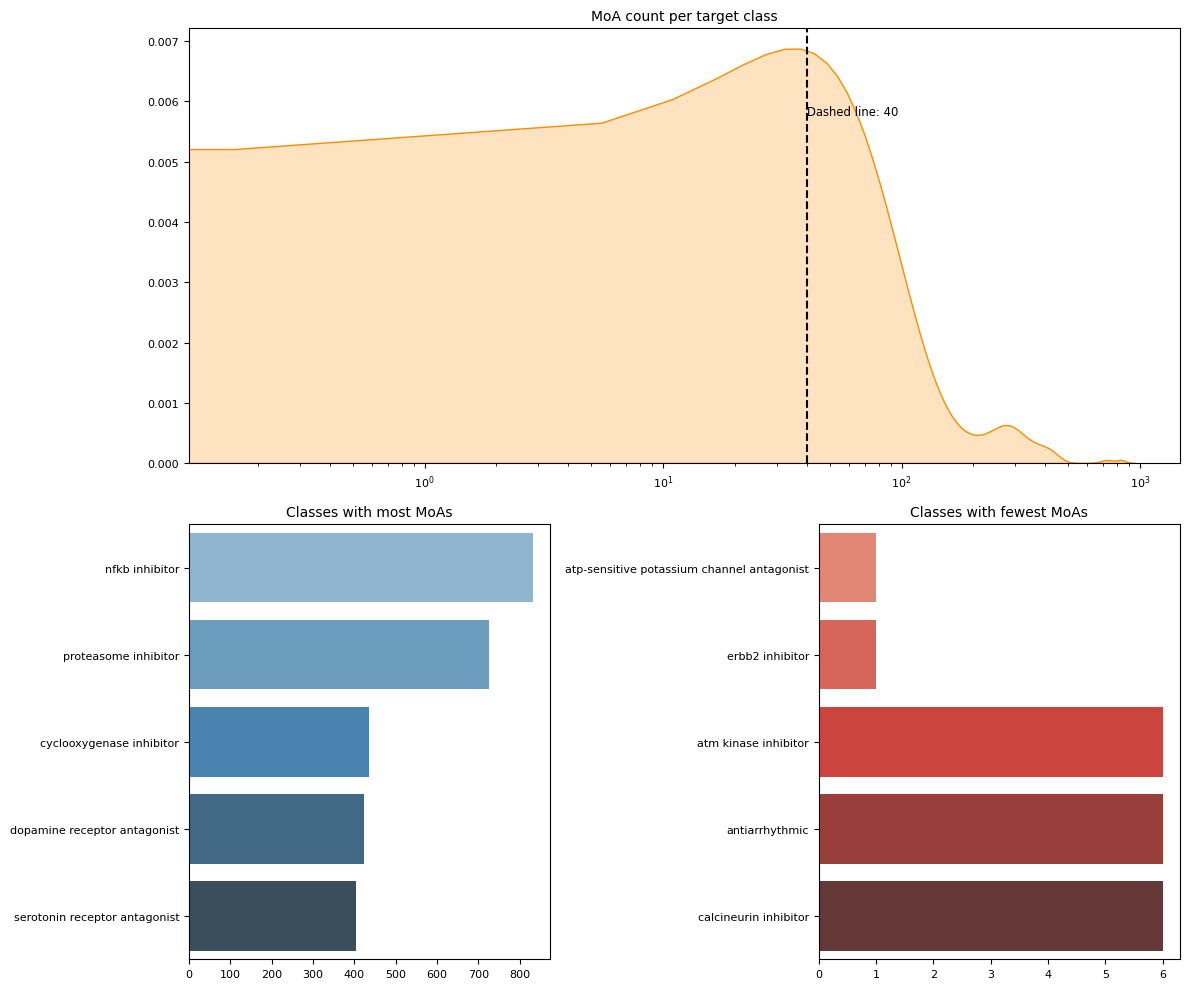

In [ ]:
# Calculate the sum of active MoAs for each target class
target_sums = train_targets_scored.drop(columns='sig_id').sum().reset_index(name='sum')
target_sums.columns = ['target', 'sum']

# Create the plots
fig = plt.figure(figsize=(12, 10))

# Plot 1: Density plot of MoA counts per target class
ax1 = fig.add_subplot(2, 1, 1)
sns.kdeplot(data=target_sums, x='sum', fill=True, color='darkorange', ax=ax1)
ax1.axvline(x=40, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_title("MoA count per target class")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.text(40, ax1.get_ylim()[1]*0.8, 'Dashed line: 40', horizontalalignment='left', size='small', color='black')
ax1.set_title("MoA count per target class", fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)


# Plot 2: Classes with most MoAs
ax2 = fig.add_subplot(2, 2, 3)
top_classes = target_sums.sort_values(by='sum', ascending=False).head(5)
top_classes['target'] = top_classes['target'].str.replace('_', ' ')
sns.barplot(x='sum', y='target', data=top_classes, palette='Blues_d', ax=ax2)
ax2.set_title("Classes with most MoAs", fontsize=10)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.xaxis.set_tick_params(labelsize=8)
ax2.yaxis.set_tick_params(labelsize=8)


# Plot 3: Classes with fewest MoAs
ax3 = fig.add_subplot(2, 2, 4)
bottom_classes = target_sums.sort_values(by='sum', ascending=True).head(5)
bottom_classes['target'] = bottom_classes['target'].str.replace('_', ' ')
sns.barplot(x='sum', y='target', data=bottom_classes, palette='Reds_d', ax=ax3)
ax3.set_title("Classes with fewest MoAs", fontsize=10)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.xaxis.set_tick_params(labelsize=8)
ax3.yaxis.set_tick_params(labelsize=8)


plt.tight_layout()
plt.show()

### For nonscored labels the cluster is at 7

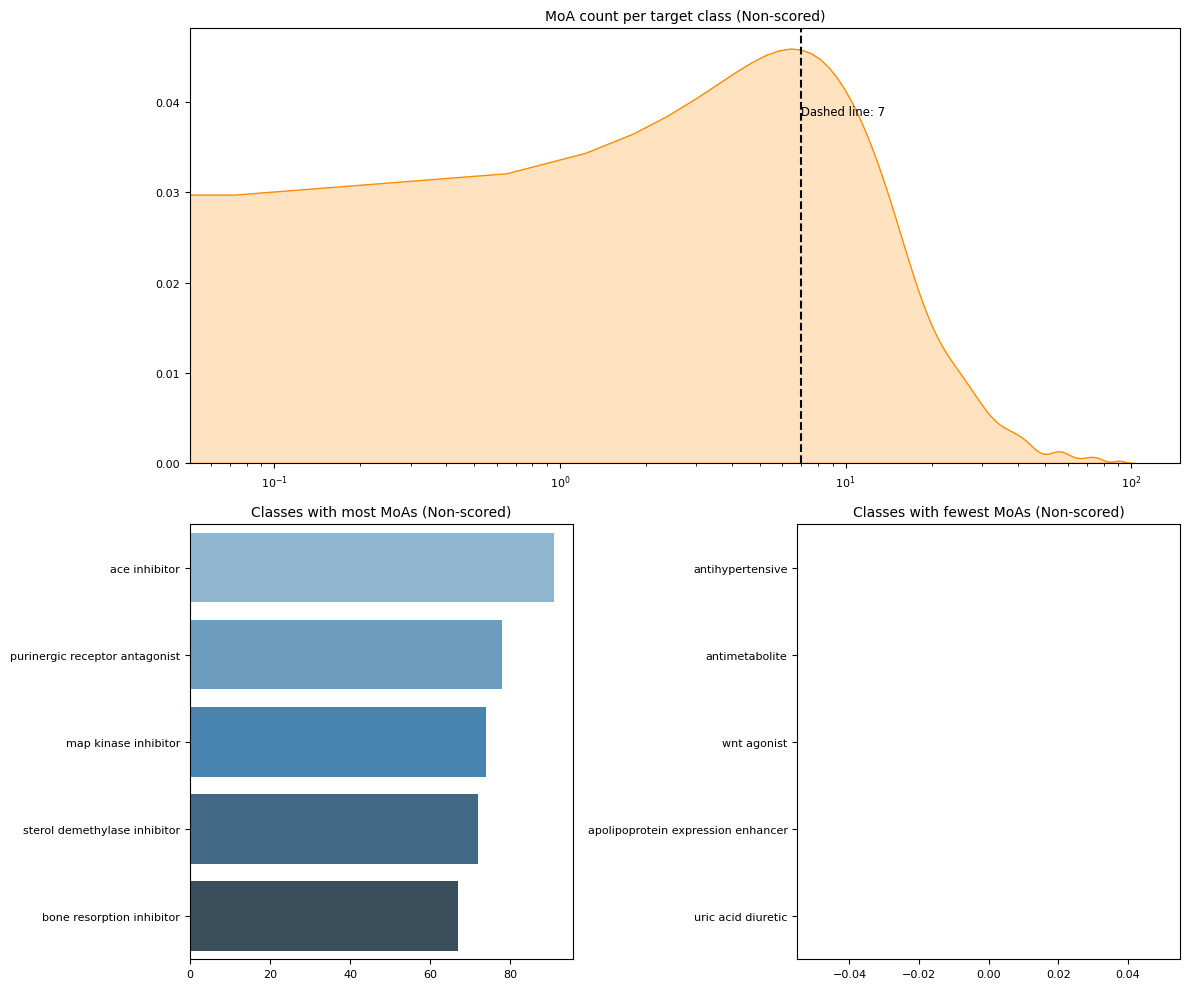

In [ ]:
# Calculate the sum of active MoAs for each target class unscored
target_sums_nonscored = train_targets_nonscored.drop(columns='sig_id').sum().reset_index(name='sum')
target_sums_nonscored.columns = ['target', 'sum']

# Create the plots
fig = plt.figure(figsize=(12, 10))

# Plot 1: Density plot of MoA counts per target class
ax1 = fig.add_subplot(2, 1, 1)
sns.kdeplot(data=target_sums_nonscored, x='sum', fill=True, color='darkorange', ax=ax1)
ax1.axvline(x=7, color='black', linestyle='--')
ax1.set_xscale('log')
ax1.set_title("MoA count per target class (Non-scored)")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.text(7, ax1.get_ylim()[1]*0.8, 'Dashed line: 7', horizontalalignment='left', size='small', color='black')
ax1.set_title("MoA count per target class (Non-scored)", fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)


# Plot 2: Classes with most MoAs
ax2 = fig.add_subplot(2, 2, 3)
top_classes_nonscored = target_sums_nonscored.sort_values(by='sum', ascending=False).head(5)
top_classes_nonscored['target'] = top_classes_nonscored['target'].str.replace('_', ' ')
sns.barplot(x='sum', y='target', data=top_classes_nonscored, palette='Blues_d', ax=ax2)
ax2.set_title("Classes with most MoAs (Non-scored)", fontsize=10)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.xaxis.set_tick_params(labelsize=8)
ax2.yaxis.set_tick_params(labelsize=8)


# Plot 3: Classes with fewest MoAs
ax3 = fig.add_subplot(2, 2, 4)
bottom_classes_nonscored = target_sums_nonscored.sort_values(by='sum', ascending=True).head(5)
bottom_classes_nonscored['target'] = bottom_classes_nonscored['target'].str.replace('_', ' ')
sns.barplot(x='sum', y='target', data=bottom_classes_nonscored, palette='Reds_d', ax=ax3)
ax3.set_title("Classes with fewest MoAs (Non-scored)", fontsize=10)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.xaxis.set_tick_params(labelsize=8)
ax3.yaxis.set_tick_params(labelsize=8)


plt.tight_layout()
plt.show()

### When we plot treatment features (duration and dosage) against a selection of random genes and cells, we observe variation, indicating that the data is suitable for learning.

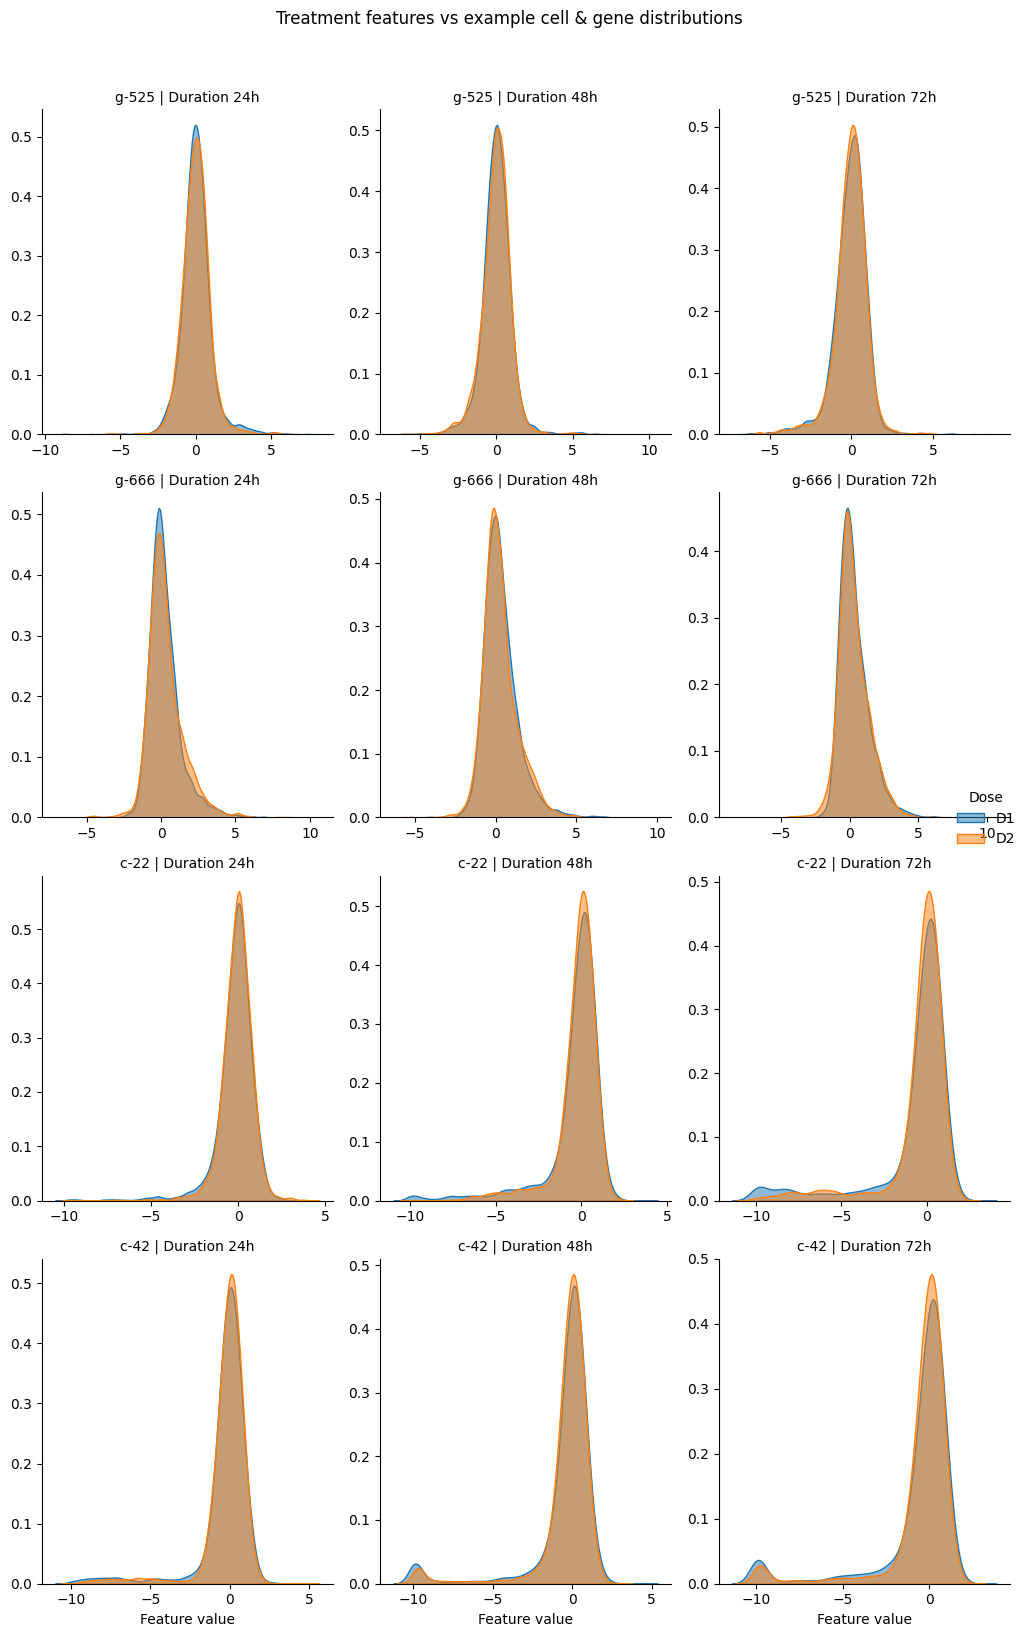

In [ ]:
# Select relevant columns
selected_cols = ['cp_dose', 'cp_time'] + [col for col in train_features.columns if col in ['g-525', 'g-666', 'c-42', 'c-22']]
plot_data = train_features[selected_cols].copy()

# Format cp_time
plot_data['cp_time'] = 'Duration ' + plot_data['cp_time'].astype(str) + 'h'

# Melt the DataFrame to long format
plot_data_long = plot_data.melt(id_vars=['cp_dose', 'cp_time'], var_name='feature', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(plot_data_long, row='feature', col='cp_time', hue='cp_dose', height=4, aspect=0.8, sharex=False, sharey=False, col_order=['Duration 24h', 'Duration 48h', 'Duration 72h'])

# Map the density plot
g.map(sns.kdeplot, 'value', fill=True, alpha=0.5)


# Add titles and labels
g.fig.suptitle("Treatment features vs example cell & gene distributions", y=1.02)
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("Feature value", "")
g.add_legend(title="Dose")

plt.tight_layout()
plt.show()

### plot data relative to control treatment

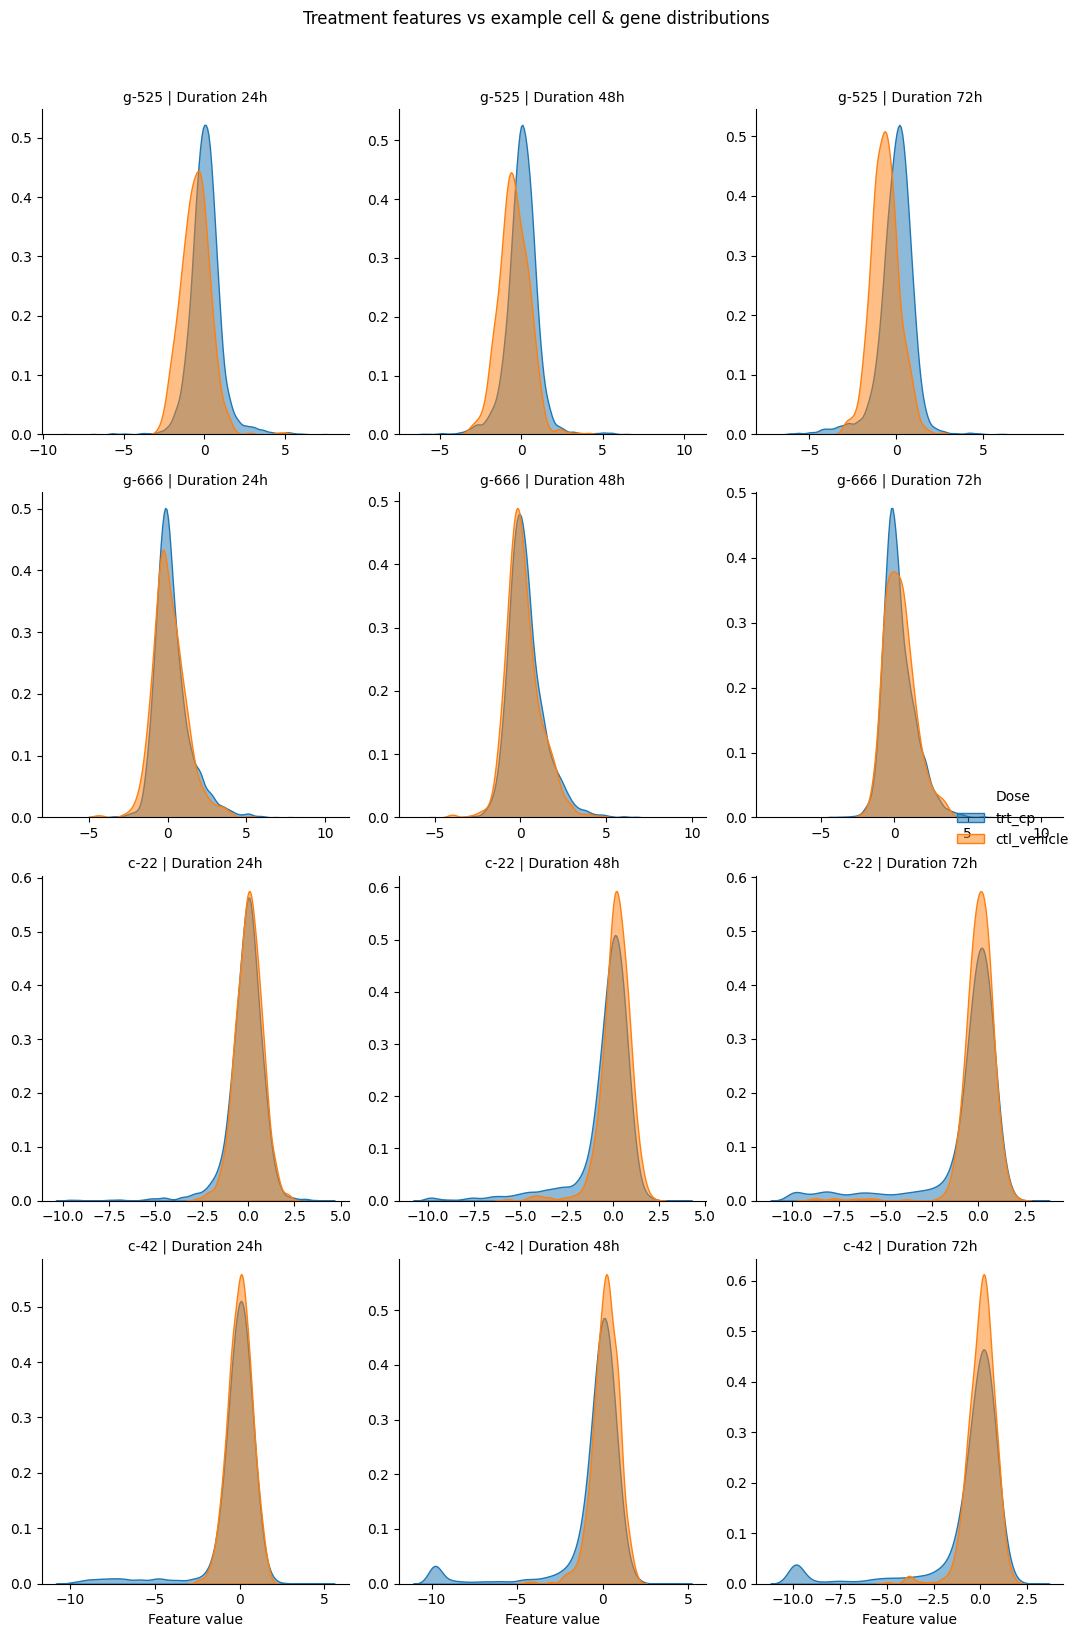

In [ ]:
# Select relevant columns
selected_cols = ['cp_type', 'cp_time'] + [col for col in train_features.columns if col in ['g-525', 'g-666', 'c-42', 'c-22']]
plot_data = train_features[selected_cols].copy()

# Format cp_time
plot_data['cp_time'] = 'Duration ' + plot_data['cp_time'].astype(str) + 'h'

# Melt the DataFrame to long format
plot_data_long = plot_data.melt(id_vars=['cp_type', 'cp_time'], var_name='feature', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(plot_data_long, row='feature', col='cp_time', hue='cp_type', height=4, aspect=0.8, sharex=False, sharey=False, col_order=['Duration 24h', 'Duration 48h', 'Duration 72h'])

# Map the density plot
g.map(sns.kdeplot, 'value', fill=True, alpha=0.5)


# Add titles and labels
g.fig.suptitle("Treatment features vs example cell & gene distributions", y=1.02)
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("Feature value", "")
g.add_legend(title="Dose")

plt.tight_layout()
plt.show()

### Find top features among genes and cells with most salient differences across treatment groups

In [ ]:


# Combine cp_time and cp_dose into a single grouping variable
train_features['treatment_group'] = train_features['cp_time'].astype(str) + '_' + train_features['cp_dose']

# Get the unique treatment groups
treatment_groups = train_features['treatment_group'].unique()

# Initialize dictionaries to store p-values for g- and c- features
g_p_values = {}
c_p_values = {}

# Perform Kruskal-Wallis test for each g- feature
for col in g_cols:
    feature_data = [train_features[train_features['treatment_group'] == group][col].dropna() for group in treatment_groups]
    if len(feature_data) > 1: # Ensure there's more than one group to compare
        try:
            statistic, p_value = kruskal(*feature_data)
            g_p_values[col] = p_value
        except ValueError:
            # Handle cases where all values in a group are identical
            g_p_values[col] = 1.0 # Assign a high p-value if test cannot be performed


# Perform Kruskal-Wallis test for each c- feature
for col in c_cols:
    feature_data = [train_features[train_features['treatment_group'] == group][col].dropna() for group in treatment_groups]
    if len(feature_data) > 1: # Ensure there's more than one group to compare
         try:
            statistic, p_value = kruskal(*feature_data)
            c_p_values[col] = p_value
         except ValueError:
            # Handle cases where all values in a group are identical
            c_p_values[col] = 1.0 # Assign a high p-value if test cannot be performed


# Convert p-values to Series and sort them
g_p_values_series = pd.Series(g_p_values).sort_values()
c_p_values_series = pd.Series(c_p_values).sort_values()

print("Top 10 g- features with most salient differences across treatment groups:")
print(g_p_values_series.head(10))

print("\nTop 10 c- features with most salient differences across treatment groups:")
print(c_p_values_series.head(10))

# Drop the temporary treatment_group column
train_features = train_features.drop(columns=['treatment_group'])

Top 10 g- features with most salient differences across treatment groups:
g-45     2.957492e-277
g-281    7.694468e-270
g-465    1.519055e-240
g-755    3.140557e-204
g-323    8.114824e-197
g-694    2.680954e-167
g-56     5.607736e-161
g-154    7.313168e-160
g-191    1.291591e-153
g-161    1.098367e-150
dtype: float64

Top 10 c- features with most salient differences across treatment groups:
c-74    3.459564e-08
c-3     2.117200e-04
c-95    9.289686e-04
c-24    1.178359e-03
c-92    1.251114e-03
c-18    1.280047e-03
c-66    4.189638e-03
c-40    4.199785e-03
c-9     5.779452e-03
c-47    7.209287e-03
dtype: float64


In [ ]:
g_p_values_series[:2].index.to_list()
c_p_values_series[:2].index.to_list()
p_values = pd.concat([g_p_values_series[:2], c_p_values_series[:2]]).index.to_list()
print(p_values)

['g-45', 'g-281', 'c-74', 'c-3']


### plot most salient differences

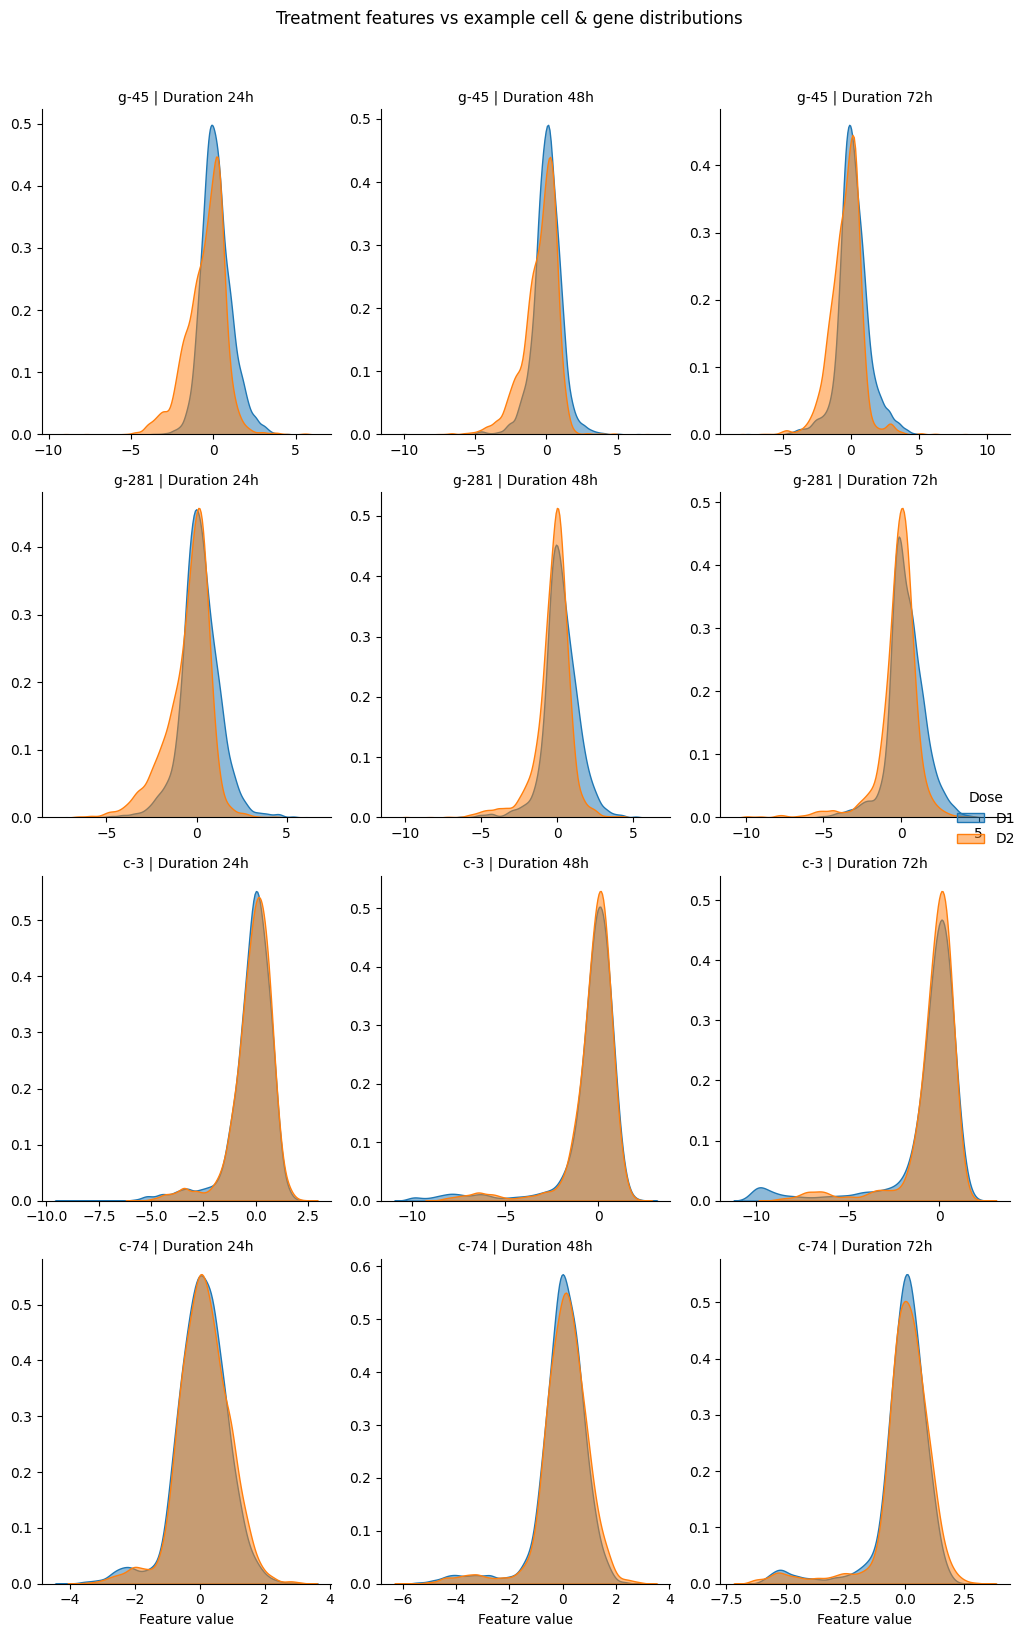

In [ ]:
# Select relevant columns
selected_cols = ['cp_dose', 'cp_time'] + [col for col in train_features.columns if col in p_values]
plot_data = train_features[selected_cols].copy()

# Format cp_time
plot_data['cp_time'] = 'Duration ' + plot_data['cp_time'].astype(str) + 'h'

# Melt the DataFrame to long format
plot_data_long = plot_data.melt(id_vars=['cp_dose', 'cp_time'], var_name='feature', value_name='value')

# Create a FacetGrid
g = sns.FacetGrid(plot_data_long, row='feature', col='cp_time', hue='cp_dose', height=4, aspect=0.8, sharex=False, sharey=False, col_order=['Duration 24h', 'Duration 48h', 'Duration 72h'])

# Map the density plot
g.map(sns.kdeplot, 'value', fill=True, alpha=0.5)


# Add titles and labels
g.fig.suptitle("Treatment features vs example cell & gene distributions", y=1.02)
g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.set_axis_labels("Feature value", "")
g.add_legend(title="Dose")

plt.tight_layout()
plt.show()

### Confirm that the control treatment produces no effect (no actions).

In [ ]:
##no row with ctl_vehicle has an action, either in scored or nonscored targets
ctl_vehicle_data = dataset[:train_len][dataset[:train_len]['cp_type'] == 'ctl_vehicle']

is_train = dataset.index < train_len
is_ctl_vehicle = dataset['cp_type'] == 'ctl_vehicle'
ctl_vehicle_data = dataset.loc[is_train & is_ctl_vehicle]


ttscored_columns = train_targets_scored.drop(['sig_id'], axis=1).columns
cvd_columns = ctl_vehicle_data[ttscored_columns]
ones = cvd_columns.eq(1).sum()
print(ones.sum())



ttnonscored_columns = train_targets_nonscored.drop(['sig_id'], axis=1).columns
cvd_columns = ctl_vehicle_data[ttnonscored_columns]
ones = cvd_columns.eq(1).sum()
print(ones.sum())

0
0


<a id="feature-engineering"></a>
## Feature engineering

label endcode cp_type

In [ ]:
cat_encoder = LabelEncoder()
dataset['cp_type'] = cat_encoder.fit_transform(dataset['cp_type'])

use custom mapping for cp_time and cp_dose to preserve proportions (starting with 1 vs 0 as in LabelEncoder would have done)

In [ ]:
cp_time_mapping = {24: 1, 48: 2, 72: 3}
dataset['cp_time'] = dataset['cp_time'].map(cp_time_mapping)

In [ ]:
cp_dose_mapping = {'D1': 1, 'D2': 2}
dataset['cp_dose'] = dataset['cp_dose'].map(cp_dose_mapping)

### add new feature

In [ ]:
dataset['cp_time*cp_dose'] = dataset['cp_time'] * dataset['cp_dose']
train_features_metadata_cols = ['cp_type', 'cp_time', 'cp_dose', 'cp_time*cp_dose']

In [ ]:
dataset[train_features_metadata_cols].head()

,cp_type,cp_time,cp_dose,cp_time*cp_dose
0,1,1,1,1
1,1,3,1,3
2,1,2,1,2
3,1,2,1,2
4,1,3,2,6


### Use QuantileTransformer to process data into an normal distribution. QT works better with skewed datasets than StandardScaler

In [ ]:
scaler_g = QuantileTransformer(output_distribution='normal', random_state=42)
scaler_c = QuantileTransformer(output_distribution='normal', random_state=42)
fit_g = scaler_g.fit(dataset.loc[:train_len-1,g_cols])#mabe i should use train_features[g_cols]
dataset[g_cols] = scaler_g.transform(dataset[g_cols])#but here is the answer: keep dataset
fit_c = scaler_c.fit(dataset.loc[:train_len-1,c_cols])
dataset[c_cols] = scaler_c.transform(dataset[c_cols])
print(dataset.head())

         sig_id  cp_type  cp_time  cp_dose       g-0       g-1       g-2  \
0  id_000644bb2        1        1        1  1.146579  0.899652 -0.425546   
1  id_000779bfc        1        3        1  0.107126  0.681881  0.269256   
2  id_000a6266a        1        2        1  0.774453  0.939654  1.408388   
3  id_0015fd391        1        2        1 -0.742645 -0.271638 -0.444530   
4  id_001626bd3        1        3        2 -0.467472 -0.480383  0.976469   

        g-3       g-4       g-5  ...  \
0 -0.965860 -0.260221 -1.007043  ...   
1  0.069095  1.222152  0.702231  ...   
2 -0.136283 -0.011291  1.486447  ...   
3  0.754919  2.475856 -0.856669  ...   
4  0.959059  1.489122 -0.865026  ...   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                        0.0                   0.0   
1                                        0.0                   0.0   
2                                        0.0                   0.0   
3                     

## With PCA, retaining 95% of the variance results in 600 gene features and 80 cell features, an 80% reduction.

In [ ]:
pca_g = PCA()
pca_g.fit(dataset[:train_len][g_cols])
cumsum = np.cumsum(pca_g.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('The number of components selected: ', d)

The number of components selected:  601


### plotting the variance shows that the 95% reduction is not at an elbow. The g-features variance elbow is at about 300

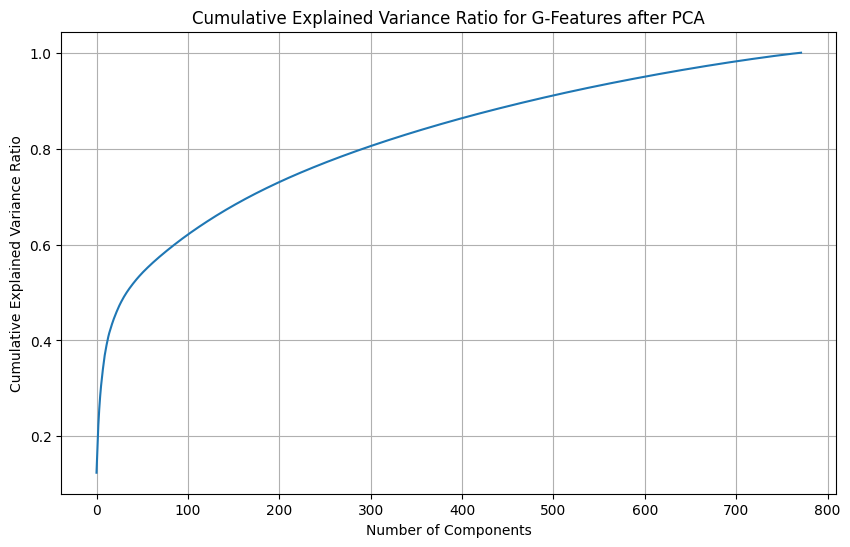

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for G-Features after PCA')
plt.grid(True)
plt.show()

In [ ]:
pca_c = PCA()
pca_c.fit(dataset[:train_len][c_cols])
cumsum = np.cumsum(pca_c.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('The number of components selected: ', d)

The number of components selected:  84


## The c-features variance is mostly linear

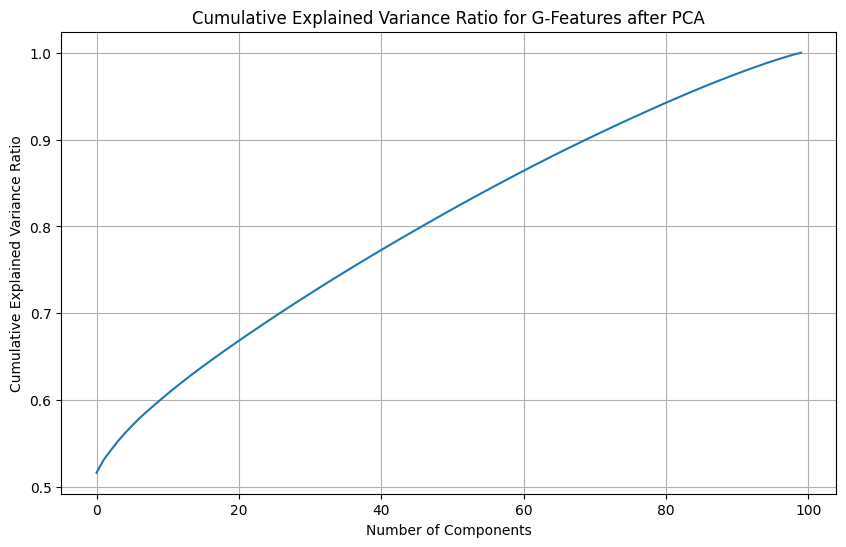

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cumsum)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for G-Features after PCA')
plt.grid(True)
plt.show()

<a id="autoencoder"></a>
## Train an autoencoder for dimensionality reduction
I chose an autoencoder because there are nonlinear relationships in the gene features and also that it may capture conections across gene-cells. Since c-features and g-features exhibit distinct data characteristics, we train a separate autoencoder for each.

In [ ]:
#hyperparameters
CONFIG = {
    "seed": 42,
    "epochs": 1000,
    "train_batch_size": 1024,
    "learning_rate": 1e-3,
    "T_max": 2000,
    "min_lr": 1e-5,
    "cat_weight": 1./3,
    "cont_weight": 2./3,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

 The autoencoder for cells has a latent representation of 64, with 3 x 2 layers (encoder + decoder)



In [ ]:


class AutoencoderC(nn.Module):
    def __init__(self, input_dim, latent_dim=64):
        super(AutoencoderC, self).__init__()
        print(f'input dim : {input_dim}')
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, latent_dim )
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),

            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, input_dim)
            # no activation → regression-like output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

The genes autoencoder features a 256-dimensional latent representation and 3 x 2 layers, each maintaining the same 256 dimensions. This architecture has been fine-tuned to achieve minimal MSE loss and optimal training efficiency



In [ ]:
class AutoencoderG(nn.Module):
    def __init__(self, input_dim, latent_dim=256):
        super(AutoencoderG, self).__init__()
        print(f'input dim : {input_dim}')
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, latent_dim )
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),

            nn.Linear(256, input_dim)
            # no activation → regression-like output
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

use MSE loss, Adam and CosineAnnealingLR learning rate scheduler

In [ ]:
autoencoder_g = AutoencoderG(input_dim=len(g_cols))
criterion_g = nn.MSELoss()
optimizer_g = torch.optim.Adam(autoencoder_g.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_g = lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])

input dim : 772


In [ ]:
autoencoder_c = AutoencoderC(input_dim=len(c_cols))
criterion_c = nn.MSELoss()
optimizer_c = torch.optim.Adam(autoencoder_c.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler_c = lr_scheduler.CosineAnnealingLR(optimizer_c, T_max=CONFIG['T_max'], eta_min=CONFIG['min_lr'])

input dim : 100


The training function for both autoencoders

In [ ]:
def run_training(model, optimizer, scheduler, loss_fn, train_loader, valid_loader, device, num_epochs, early_stopping_steps, early_stop):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    else:
        print("[INFO] Using CPU\n")

    if len(train_loader) == 0 or len(valid_loader) == 0:
        raise ValueError("DataLoader is empty")

    model = model.to(device)
    early_step = 0
    best_loss = np.inf
    train_losses = []  # Track training loss per epoch
    valid_losses = []  # Track validation loss per epoch

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, targets = batch['x'].to(device), batch['y'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        scheduler.step()
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {avg_train_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, targets = batch['x'].to(device), batch['y'].to(device)
                outputs = model(inputs)
                val_loss += loss_fn(outputs, targets).item()
        avg_val_loss = val_loss / len(valid_loader)
        valid_losses.append(avg_val_loss)
        print(f'Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            early_step = 0
            # torch.save(model.state_dict(), 'best_model.pth')  # Uncomment to save model
        elif early_stop:
            early_step += 1
            print(f"  Early stopping step: {early_step}/{early_stopping_steps}")
            if early_step >= early_stopping_steps:
                print(f"  Early stopping triggered.")
                break

    return best_loss, train_losses, valid_losses

Create a simple dataset class for autoencoder training

In [ ]:
class AutoencoderDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.features[idx, :], dtype=torch.float) # Target is the same as input
        }
        return dct

Train autoencoder for cells. Use minimum number of epochs because if increased, doesn't give better result downstream.

In [ ]:
# Prepare data for autoencoder training
c_features = dataset.loc[:train_len-1, c_cols].to_numpy(dtype=np.float32)


# Split data into training and validation sets for autoencoder
c_train, c_valid = train_test_split(c_features, test_size=0.2, random_state=CONFIG['seed'])

# Create data loaders
train_c_dataset = AutoencoderDataset(c_train)
valid_c_dataset = AutoencoderDataset(c_valid)
train_c_loader = DataLoader(train_c_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True)
valid_c_loader = DataLoader(valid_c_dataset, batch_size=CONFIG['train_batch_size'], shuffle=False)


# Define loss function for autoencoder (MSELoss)
criterion_c = nn.MSELoss()

# Move the model to the device
autoencoder_c.to(CONFIG['device'])
print('before model_run_c')

# Run training for the c- autoencoder
model_run_c, train_losses, valid_losses = run_training(
    model=autoencoder_c,
    optimizer=optimizer_c,
    scheduler=scheduler_c,
    loss_fn=criterion_c,
    train_loader=train_c_loader,
    valid_loader=valid_c_loader,
    device=CONFIG['device'],
    # num_epochs=CONFIG['epochs'],
    num_epochs=50,
    early_stopping_steps=10,
    early_stop=False
)

print(f"Best validation loss for c- autoencoder: {model_run_c:.4f}")

# Save the trained model state dictionary
torch.save(autoencoder_c.state_dict(), output_path + 'autoencoder_c.pth')

before model_run_c
[INFO] Using GPU: Tesla T4

Epoch [1/50], Loss: 0.8665
Validation Loss: 0.5776
Epoch [2/50], Loss: 0.5551
Validation Loss: 0.5213
Epoch [3/50], Loss: 0.5157
Validation Loss: 0.4961
Epoch [4/50], Loss: 0.4929
Validation Loss: 0.4788
Epoch [5/50], Loss: 0.4728
Validation Loss: 0.4604
Epoch [6/50], Loss: 0.4553
Validation Loss: 0.4434
Epoch [7/50], Loss: 0.4369
Validation Loss: 0.4258
Epoch [8/50], Loss: 0.4206
Validation Loss: 0.4103
Epoch [9/50], Loss: 0.4040
Validation Loss: 0.3940
Epoch [10/50], Loss: 0.3879
Validation Loss: 0.3812
Epoch [11/50], Loss: 0.3763
Validation Loss: 0.3700
Epoch [12/50], Loss: 0.3659
Validation Loss: 0.3591
Epoch [13/50], Loss: 0.3573
Validation Loss: 0.3535
Epoch [14/50], Loss: 0.3469
Validation Loss: 0.3487
Epoch [15/50], Loss: 0.3395
Validation Loss: 0.3392
Epoch [16/50], Loss: 0.3324
Validation Loss: 0.3316
Epoch [17/50], Loss: 0.3250
Validation Loss: 0.3271
Epoch [18/50], Loss: 0.3198
Validation Loss: 0.3171
Epoch [19/50], Loss: 0.313

### We observe loss falling until the 50th epoch, then reaching a plateau

In [ ]:
def plot_losses(train_losses, valid_losses, num_epochs):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, label='Training Loss', marker='o')
    plt.plot(epochs, valid_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()

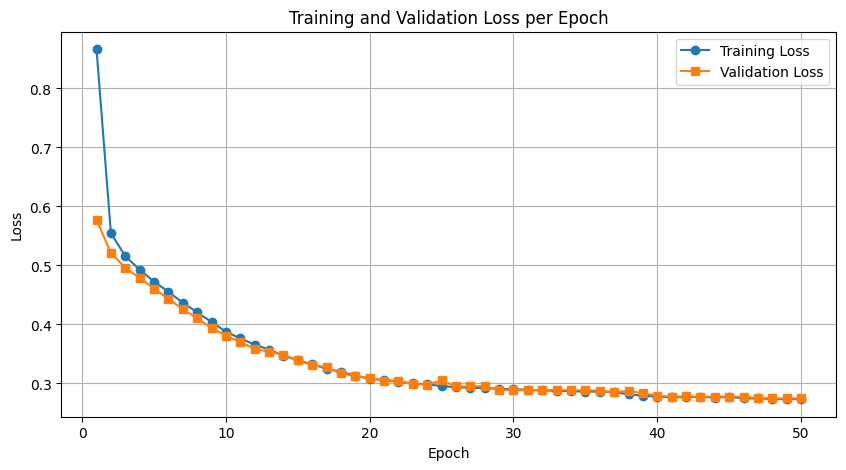

In [ ]:
plot_losses(train_losses, valid_losses, num_epochs=100)

Train the autoencoder for gene features

In [ ]:
# Prepare data for autoencoder training
g_features = dataset.loc[:train_len-1, g_cols].to_numpy(dtype=np.float32)

# Split data into training and validation sets for autoencoder
g_train, g_valid = train_test_split(g_features, test_size=0.2, random_state=CONFIG['seed'])

# Create data loaders
train_g_dataset = AutoencoderDataset(g_train)
valid_g_dataset = AutoencoderDataset(g_valid)
train_g_loader = DataLoader(train_g_dataset, batch_size=CONFIG['train_batch_size'], shuffle=True)
valid_g_loader = DataLoader(valid_g_dataset, batch_size=CONFIG['train_batch_size'], shuffle=False)


# Define loss function for autoencoder (MSELoss)
criterion_g = nn.MSELoss()

# Move the model to the device
autoencoder_g.to(CONFIG['device'])
print('before model_run_g')

# Run training for the c- autoencoder
model_run_g, train_losses, valid_losses = run_training(
    model=autoencoder_g,
    optimizer=optimizer_g,
    scheduler=scheduler_g,
    loss_fn=criterion_g,
    train_loader=train_g_loader,
    valid_loader=valid_g_loader,
    device=CONFIG['device'],
    # num_epochs=CONFIG['epochs'],
    num_epochs=100,
    early_stopping_steps=10,
    early_stop=False
)

print(f"Best validation loss for c- autoencoder: {model_run_g:.4f}")

# Save the trained model state dictionary
torch.save(autoencoder_g.state_dict(), output_path +  'autoencoder_g.pth')

before model_run_g
[INFO] Using GPU: Tesla T4

Epoch [1/100], Loss: 0.8932
Validation Loss: 0.7288
Epoch [2/100], Loss: 0.6852
Validation Loss: 0.6482
Epoch [3/100], Loss: 0.6300
Validation Loss: 0.6105
Epoch [4/100], Loss: 0.6000
Validation Loss: 0.5871
Epoch [5/100], Loss: 0.5792
Validation Loss: 0.5701
Epoch [6/100], Loss: 0.5612
Validation Loss: 0.5543
Epoch [7/100], Loss: 0.5459
Validation Loss: 0.5417
Epoch [8/100], Loss: 0.5333
Validation Loss: 0.5317
Epoch [9/100], Loss: 0.5233
Validation Loss: 0.5222
Epoch [10/100], Loss: 0.5134
Validation Loss: 0.5126
Epoch [11/100], Loss: 0.5042
Validation Loss: 0.5054
Epoch [12/100], Loss: 0.4966
Validation Loss: 0.4977
Epoch [13/100], Loss: 0.4884
Validation Loss: 0.4930
Epoch [14/100], Loss: 0.4812
Validation Loss: 0.4841
Epoch [15/100], Loss: 0.4751
Validation Loss: 0.4792
Epoch [16/100], Loss: 0.4675
Validation Loss: 0.4700
Epoch [17/100], Loss: 0.4593
Validation Loss: 0.4645
Epoch [18/100], Loss: 0.4533
Validation Loss: 0.4570
Epoch [1

### The loss is falling until the 100th epoch

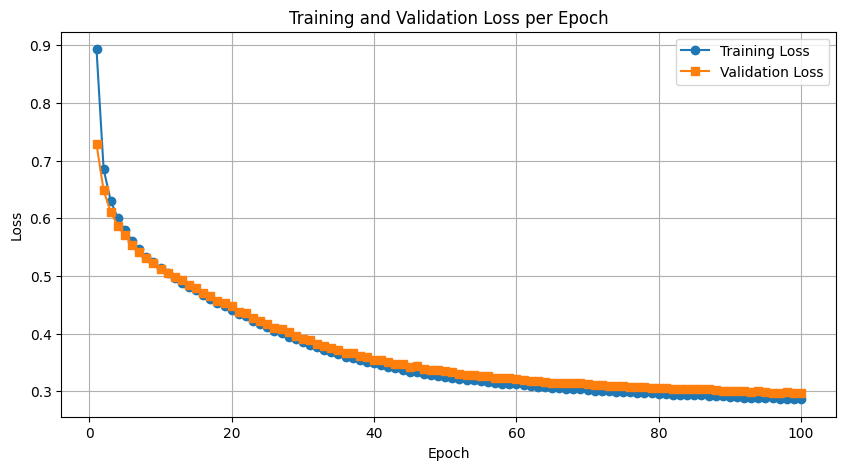

In [ ]:
plot_losses(train_losses, valid_losses, num_epochs=100)

 Create datasets and dataloaders for encoding.
 Reuse AutoencoderDataset, but targets are not needed for encoding

In [ ]:

class EncodingDataset(Dataset):
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct

### Reduce data dimensions and create new dataframes

In [ ]:
# Assuming the autoencoders are saved
# torch.save(autoencoder_c.state_dict(), 'autoencoder_c.pth')
# torch.save(autoencoder_g.state_dict(), 'autoencoder_g.pth')

# Load the trained autoencoder models
autoencoder_c = AutoencoderC(input_dim=len(c_cols)) # Make sure encoding_dim is correct
autoencoder_c.load_state_dict(torch.load(output_path + 'autoencoder_c.pth'))
autoencoder_c.to(CONFIG['device'])
autoencoder_c.eval() # Set to evaluation mode

autoencoder_g = AutoencoderG(input_dim=len(g_cols)) # Make sure encoding_dim is correct
autoencoder_g.load_state_dict(torch.load(output_path + 'autoencoder_g.pth'))
autoencoder_g.to(CONFIG['device'])
autoencoder_g.eval() # Set to evaluation mode


# Function to encode data using a trained autoencoder
def encode_data(model, dataloader, device):
    encoded_features = []
    with torch.no_grad():
        for data in dataloader:
            inputs = data['x'].to(device)
            encoded = model.encoder(inputs)
            encoded_features.append(encoded.cpu().numpy())
    return np.concatenate(encoded_features)

# Prepare data for encoding
train_c_features = dataset.loc[:train_len-1, c_cols].to_numpy(dtype=np.float32)
test_c_features = dataset.loc[train_len:, c_cols].to_numpy(dtype=np.float32)
train_g_features = dataset.loc[:train_len-1,g_cols].to_numpy(dtype=np.float32)
test_g_features = dataset.loc[train_len:,g_cols].to_numpy(dtype=np.float32)


train_c_dataset_enc = EncodingDataset(train_c_features)
test_c_dataset_enc = EncodingDataset(test_c_features)
train_g_dataset_enc = EncodingDataset(train_g_features)
test_g_dataset_enc = EncodingDataset(test_g_features)


train_c_loader_enc = DataLoader(train_c_dataset_enc, batch_size=CONFIG['train_batch_size'], shuffle=False)
test_c_loader_enc = DataLoader(test_c_dataset_enc, batch_size=CONFIG['train_batch_size'], shuffle=False)
train_g_loader_enc = DataLoader(train_g_dataset_enc, batch_size=CONFIG['train_batch_size'], shuffle=False)
test_g_loader_enc = DataLoader(test_g_dataset_enc, batch_size=CONFIG['train_batch_size'], shuffle=False)


# Encode the training and test data
train_c_encoded = encode_data(autoencoder_c, train_c_loader_enc, CONFIG['device'])
test_c_encoded = encode_data(autoencoder_c, test_c_loader_enc, CONFIG['device'])
train_g_encoded = encode_data(autoencoder_g, train_g_loader_enc, CONFIG['device'])
test_g_encoded = encode_data(autoencoder_g, test_g_loader_enc, CONFIG['device'])

# Create DataFrames from encoded features
train_c_encoded_df = pd.DataFrame(train_c_encoded, columns=[f'ae_C-{i}' for i in range(train_c_encoded.shape[1])])
test_c_encoded_df = pd.DataFrame(test_c_encoded, columns=[f'ae_C-{i}' for i in range(test_c_encoded.shape[1])])
train_g_encoded_df = pd.DataFrame(train_g_encoded, columns=[f'ae_G-{i}' for i in range(train_g_encoded.shape[1])])
test_g_encoded_df = pd.DataFrame(test_g_encoded, columns=[f'ae_G-{i}' for i in range(test_g_encoded.shape[1])])


# Combine with non-feature columns
train_features_reduced = pd.concat([dataset.loc[:train_len-1,['sig_id', 'cp_type', 'cp_time', 'cp_dose','cp_time*cp_dose']], train_c_encoded_df, train_g_encoded_df], axis=1)
test_features_reduced = pd.concat([dataset.loc[train_len:,['sig_id', 'cp_type', 'cp_time', 'cp_dose','cp_time*cp_dose']].reset_index(), test_c_encoded_df, test_g_encoded_df], axis=1)

print("Reduced training features shape:", train_features_reduced.shape)
print("Reduced test features shape:", test_features_reduced.shape)

display(train_features_reduced.head())
display(test_features_reduced.head())

dataset_reduced = pd.concat([train_features_reduced, test_features_reduced.set_index('index')])
print(dataset_reduced.tail())
print(dataset.tail())

input dim : 100
input dim : 772
Reduced training features shape: (23814, 325)
Reduced test features shape: (3982, 326)


,sig_id,cp_type,cp_time,cp_dose,cp_time*cp_dose,ae_C-0,ae_C-1,ae_C-2,ae_C-3,ae_C-4,...,ae_G-246,ae_G-247,ae_G-248,ae_G-249,ae_G-250,ae_G-251,ae_G-252,ae_G-253,ae_G-254,ae_G-255
0,id_000644bb2,1,1,1,1,1.195582,-0.696698,-0.184301,-0.278372,0.458891,...,-0.681996,-1.393105,-0.346707,0.595839,0.285791,0.634499,1.240778,-0.471850,0.179099,-0.978138
1,id_000779bfc,1,3,1,3,1.320823,-0.753896,-0.411413,-0.211089,0.491321,...,-0.977888,-0.806160,-1.011250,0.828274,-0.410738,-0.009274,0.878959,-0.372776,-0.146871,0.329854
2,id_000a6266a,1,2,1,2,0.818387,-0.580639,0.238502,-0.342360,0.551604,...,-0.879102,-0.626214,-0.414618,0.817359,-0.481961,0.892120,-0.821125,-0.610812,0.302451,-0.402652
3,id_0015fd391,1,2,1,2,0.139294,-0.476360,0.073292,-0.087831,0.918333,...,-0.389186,-0.206709,-0.650991,-0.688186,-0.026285,1.113866,-0.534549,-1.116274,0.217202,-0.707149
4,id_001626bd3,1,3,2,6,0.997042,-0.460862,-0.167508,-1.105518,0.596147,...,-1.001851,-0.343874,-0.783498,1.158531,-0.225493,0.338735,0.628498,-0.311343,0.140340,-0.373407


,index,sig_id,cp_type,cp_time,cp_dose,cp_time*cp_dose,ae_C-0,ae_C-1,ae_C-2,ae_C-3,...,ae_G-246,ae_G-247,ae_G-248,ae_G-249,ae_G-250,ae_G-251,ae_G-252,ae_G-253,ae_G-254,ae_G-255
0,23814,id_0004d9e33,1,1,1,1,0.653632,-0.250510,-0.605916,-0.474608,...,-0.741518,-0.266956,-0.139424,0.739735,-0.224691,0.789111,0.101964,-0.019343,-0.016314,-0.503273
1,23815,id_001897cda,1,3,1,3,-0.079296,0.023405,0.221829,0.126757,...,-0.207439,-1.519758,-0.305992,0.270396,0.136645,0.786517,0.524534,-0.962993,-0.063516,-1.030488
2,23816,id_002429b5b,0,1,1,1,0.585301,-0.510647,-0.587412,-0.030942,...,-0.415918,-0.694442,-0.725711,0.745369,0.716364,0.115347,1.372034,-0.653452,0.141612,-0.361313
3,23817,id_00276f245,1,1,2,2,0.865750,-0.384080,-0.026524,-0.261259,...,0.217042,-0.999730,-0.376575,-0.105582,0.126314,0.818779,0.357368,-0.231070,0.066205,-0.624968
4,23818,id_0027f1083,1,2,1,2,1.140002,-1.053389,-0.180754,0.011501,...,-0.899088,-1.348889,-0.680014,0.355016,0.296925,0.572328,1.286738,-0.334674,0.002018,-0.635404


             sig_id  cp_type  cp_time  cp_dose  cp_time*cp_dose    ae_C-0  \
27791  id_ff7004b87        1        1        1                1  0.323158   
27792  id_ff925dd0d        1        1        1                1  0.715965   
27793  id_ffb710450        1        3        1                3  0.922963   
27794  id_ffbb869f2        1        2        2                4  0.786930   
27795  id_ffd5800b6        1        3        1                3  0.845269   

         ae_C-1    ae_C-2    ae_C-3    ae_C-4  ...  ae_G-246  ae_G-247  \
27791 -0.058684  0.122451 -0.126637  0.450798  ... -0.618798 -1.156996   
27792 -0.321448 -0.325644  0.435790  1.253904  ... -0.295277 -1.243471   
27793 -0.443398  0.204326  0.128427  0.846275  ... -0.243002 -1.982263   
27794 -0.042525 -0.325494 -0.236080  0.817709  ... -0.996641 -1.051355   
27795 -0.586014 -0.470664 -0.402453  0.195372  ...  0.124433 -0.873267   

       ae_G-248  ae_G-249  ae_G-250  ae_G-251  ae_G-252  ae_G-253  ae_G-254  \
27791 -0.3099

build one big dataframe; also select into variables new column names for processed genes and cells

In [ ]:
train_processed = (
    train_features_reduced
    .merge(train_targets_all, on='sig_id')
    .query("cp_type != 0")
    .drop(columns='cp_type')
    .reset_index(drop=True)
)
train_len = len(train_processed)

test_processed = (
    test_features_reduced
    .query("cp_type != 0")
    .drop(columns=['index', 'cp_type'], errors='ignore')
    .reset_index(drop=True)
)
test_len = len(test_processed)

dataset_reduced = pd.concat([train_processed, test_processed], ignore_index=True)

g_cols = [col for col in dataset_reduced.columns if col.startswith('pca_G')]
c_cols = [col for col in dataset_reduced.columns if col.startswith('pca_C')]



In [ ]:
print(dataset_reduced.head())

         sig_id  cp_time  cp_dose  cp_time*cp_dose    ae_C-0    ae_C-1  \
0  id_000644bb2        1        1                1  1.195582 -0.696698   
1  id_000779bfc        3        1                3  1.320823 -0.753896   
2  id_000a6266a        2        1                2  0.818387 -0.580639   
3  id_0015fd391        2        1                2  0.139294 -0.476360   
4  id_001626bd3        3        2                6  0.997042 -0.460862   

     ae_C-2    ae_C-3    ae_C-4    ae_C-5  ...  ve-cadherin_antagonist  \
0 -0.184301 -0.278372  0.458891  0.128798  ...                     0.0   
1 -0.411413 -0.211089  0.491321 -0.019672  ...                     0.0   
2  0.238502 -0.342360  0.551604 -0.520704  ...                     0.0   
3  0.073292 -0.087831  0.918333 -0.980363  ...                     0.0   
4 -0.167508 -1.105518  0.596147 -0.407675  ...                     0.0   

   vesicular_monoamine_transporter_inhibitor  vitamin_k_antagonist  \
0                                       

In [ ]:
#save column names for features and targets apart
feature_columns = [col for col in dataset_reduced.columns if col not in train_targets_all.columns]
target_columns = [col for col in train_targets_all.columns if col != 'sig_id']
print(feature_columns)
dataset_reduced_index = dataset_reduced['sig_id'] # save the index
print(len(dataset_reduced_index))


['cp_time', 'cp_dose', 'cp_time*cp_dose', 'ae_C-0', 'ae_C-1', 'ae_C-2', 'ae_C-3', 'ae_C-4', 'ae_C-5', 'ae_C-6', 'ae_C-7', 'ae_C-8', 'ae_C-9', 'ae_C-10', 'ae_C-11', 'ae_C-12', 'ae_C-13', 'ae_C-14', 'ae_C-15', 'ae_C-16', 'ae_C-17', 'ae_C-18', 'ae_C-19', 'ae_C-20', 'ae_C-21', 'ae_C-22', 'ae_C-23', 'ae_C-24', 'ae_C-25', 'ae_C-26', 'ae_C-27', 'ae_C-28', 'ae_C-29', 'ae_C-30', 'ae_C-31', 'ae_C-32', 'ae_C-33', 'ae_C-34', 'ae_C-35', 'ae_C-36', 'ae_C-37', 'ae_C-38', 'ae_C-39', 'ae_C-40', 'ae_C-41', 'ae_C-42', 'ae_C-43', 'ae_C-44', 'ae_C-45', 'ae_C-46', 'ae_C-47', 'ae_C-48', 'ae_C-49', 'ae_C-50', 'ae_C-51', 'ae_C-52', 'ae_C-53', 'ae_C-54', 'ae_C-55', 'ae_C-56', 'ae_C-57', 'ae_C-58', 'ae_C-59', 'ae_C-60', 'ae_C-61', 'ae_C-62', 'ae_C-63', 'ae_G-0', 'ae_G-1', 'ae_G-2', 'ae_G-3', 'ae_G-4', 'ae_G-5', 'ae_G-6', 'ae_G-7', 'ae_G-8', 'ae_G-9', 'ae_G-10', 'ae_G-11', 'ae_G-12', 'ae_G-13', 'ae_G-14', 'ae_G-15', 'ae_G-16', 'ae_G-17', 'ae_G-18', 'ae_G-19', 'ae_G-20', 'ae_G-21', 'ae_G-22', 'ae_G-23', 'ae_G-24',

In [ ]:
print(target_columns)
print(feature_columns)
print(dataset_reduced.head())

['5-alpha_reductase_inhibitor', '11-beta-hsd1_inhibitor', 'acat_inhibitor', 'acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'acetylcholinesterase_inhibitor', 'adenosine_receptor_agonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'adrenergic_receptor_agonist', 'adrenergic_receptor_antagonist', 'akt_inhibitor', 'aldehyde_dehydrogenase_inhibitor', 'alk_inhibitor', 'ampk_activator', 'analgesic', 'androgen_receptor_agonist', 'androgen_receptor_antagonist', 'anesthetic_-_local', 'angiogenesis_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'antibiotic', 'anticonvulsant', 'antifungal', 'antihistamine', 'antimalarial', 'antioxidant', 'antiprotozoal', 'antiviral', 'apoptosis_stimulant', 'aromatase_inhibitor', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atpase_inhibitor', 'atr_kinase_inhibitor', 'aurora_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_30s_ri

### Use multilabel stratified kfold for preserving data structure, which we saw that is imbalanced

In [ ]:
folds = dataset_reduced[:train_len].copy()

X = folds[feature_columns].values  # Features
y = folds[target_columns].values  # Multi-label targets (2D array)


n_splits = 5  # Number of folds
mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

print("Generating fold splits...")
fold_splits = list(mskf.split(X, y))

for fold, (train_idx, val_idx) in enumerate(fold_splits):
    folds.loc[val_idx, 'kfold'] = int(fold)

folds['kfold'] = folds['kfold'].astype(int)
print("DataFrame with 'kfold' column added:")
print(folds)
print(folds.shape)


Generating fold splits...
DataFrame with 'kfold' column added:
             sig_id  cp_time  cp_dose  cp_time*cp_dose    ae_C-0    ae_C-1  \
0      id_000644bb2        1        1                1  1.195582 -0.696698   
1      id_000779bfc        3        1                3  1.320823 -0.753896   
2      id_000a6266a        2        1                2  0.818387 -0.580639   
3      id_0015fd391        2        1                2  0.139294 -0.476360   
4      id_001626bd3        3        2                6  0.997042 -0.460862   
...             ...      ...      ...              ...       ...       ...   
21943  id_fff8c2444        3        1                3  0.409697 -0.478305   
21944  id_fffb1ceed        1        2                2  0.570919 -0.676310   
21945  id_fffb70c0c        1        2                2  0.582893  0.201827   
21946  id_fffcb9e7c        1        1                1  1.439992 -0.510221   
21947  id_ffffdd77b        3        1                3  0.125638 -0.220824   



In [ ]:
print(folds.head())

         sig_id  cp_time  cp_dose  cp_time*cp_dose    ae_C-0    ae_C-1  \
0  id_000644bb2        1        1                1  1.195582 -0.696698   
1  id_000779bfc        3        1                3  1.320823 -0.753896   
2  id_000a6266a        2        1                2  0.818387 -0.580639   
3  id_0015fd391        2        1                2  0.139294 -0.476360   
4  id_001626bd3        3        2                6  0.997042 -0.460862   

     ae_C-2    ae_C-3    ae_C-4    ae_C-5  ...  vitamin_k_antagonist  \
0 -0.184301 -0.278372  0.458891  0.128798  ...                   0.0   
1 -0.411413 -0.211089  0.491321 -0.019672  ...                   0.0   
2  0.238502 -0.342360  0.551604 -0.520704  ...                   0.0   
3  0.073292 -0.087831  0.918333 -0.980363  ...                   0.0   
4 -0.167508 -1.105518  0.596147 -0.407675  ...                   0.0   

   voltage-gated_calcium_channel_ligand  \
0                                   0.0   
1                                   

### Since data is imbalanced, compute weights for each label to be used in the loss function of the neural network model.Capp them at 20. This is WIP

In [ ]:
pos_weights_per_fold = []

for fold_num, (train_idx, val_idx) in enumerate(fold_splits):
    print(f"Processing Fold {fold_num + 1}")

    # Get training data for this fold
    train_df = folds.iloc[train_idx]
    val_df = folds.iloc[val_idx]
    print(f"  Train set size: {len(train_df)}, Validation set size: {len(val_df)}")

    # Get the target columns for the training set only
    y_train_matrix = train_df[target_columns].values

    # Calculate pos_weight for each target class in this fold
    num_positives = np.sum(y_train_matrix, axis=0)
    num_negatives = y_train_matrix.shape[0] - num_positives

    # Compute pos_weight = number_of_negatives / number_of_positives
    # Avoid division by zero for classes with no positive samples
    # pos_weight = np.where(num_positives > 0, num_negatives / num_positives, 1.0)
    pos_weight = np.where(num_positives > 0, num_negatives / (num_positives + 1.0), 1.0)
    pos_weight = np.minimum(pos_weight, 20.0)

    # Convert to a PyTorch tensor and move to the correct device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    pos_weight_tensor = torch.tensor(pos_weight, dtype=torch.float).to(device)

    # Store pos_weight tensor for this fold
    pos_weights_per_fold.append(pos_weight_tensor)

    print(f"Using device: {device}")
    print(f"Calculated pos_weight tensor for fold {fold_num + 1}: {pos_weight_tensor}")

Processing Fold 1
  Train set size: 17559, Validation set size: 4389
Using device: cuda
Calculated pos_weight tensor for fold 1: tensor([20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
        20., 

<a id="model-training"></a>
## Model training

dataset class

In [ ]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)
        }
        return dct

class TestDataset:
    def __init__(self, features):
        self.features = features

    def __len__(self):
        return (self.features.shape[0])

    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct


Functions for the neural network model. The train and validation use different loss functions

In [ ]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0

    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
        if targets is None:
            raise ValueError("Targets is None in DataLoader")
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
        optimizer.step()
        final_loss += loss.item()

    final_loss /= len(dataloader)

    # Move scheduler step outside the loop
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(final_loss)
    else:
        scheduler.step()

    return final_loss

def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []

    with torch.no_grad():  # Add no_grad
        for data in dataloader:
            inputs, targets = data['x'].to(device), data['y'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            final_loss += loss.item()
            valid_preds.append(outputs.sigmoid().detach().cpu().numpy())

    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)

    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []

    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)

        preds.append(outputs.sigmoid().detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds



The model uses 4 layers, with batch normalization and dropout. There is no activation function on the output layer as this is computed in the loss function for performance. num_features is aproximately 325 and num_targets 610. The model has been optimized relative to parameter size, number of layers, dropout rate and hyperparameters

In [ ]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets):
        super(Model, self).__init__()
        self.dense1 = nn.Linear(num_features, 1024)
        self.batch_norm1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.2)  # Reduced slightly to allow more learning

        self.dense2 = nn.Linear(1024, 512)
        self.batch_norm2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.2)

        self.dense3 = nn.Linear(512, 256)
        self.batch_norm3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.2)

        self.dense4 = nn.Linear(256, num_targets)

    def forward(self, x):
        x = x.float()
        x = F.relu(self.dense1(x))
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = F.relu(self.dense2(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = F.relu(self.dense3(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x = self.dense4(x)  # No activation/BatchNorm/Dropout on output for logits

        return x

Hyperparameters. It uses early stopping

In [ ]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 100
BATCH_SIZE = 256
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = True

num_features=len(feature_columns)
num_targets=len(target_columns)

The loss function employs binary cross-entropy with logits, as the model outputs raw logits, aligning with the MoA competition's log loss scoring metric. Label smoothing is applied to mitigate the competition's penalty on overly confident predictions.

In [ ]:
class LabelSmoothingBCEWithLogitsLoss(nn.Module):
    def __init__(self, smoothing=0.01, pos_weight=None, max_pos_weight=100):
        super(LabelSmoothingBCEWithLogitsLoss, self).__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight  # Tensor of shape [num_targets]
        self.max_pos_weight = max_pos_weight  # Clip to prevent explosion (None to disable)

    def forward(self, pred, target):
        # Apply label smoothing: target=1 -> 1 - s, target=0 -> s
        target_smooth = target * (1 - self.smoothing) + (1 - target) * self.smoothing

        # Optional: Clamp for safety (prevents extremes if smoothing is large)
        target_smooth = torch.clamp(target_smooth, self.smoothing, 1 - self.smoothing)

        # Clip pos_weight if enabled (to handle extreme imbalance)
        pos_weight = self.pos_weight
        if self.max_pos_weight is not None and pos_weight is not None:
            pos_weight = torch.clamp(pos_weight, max=self.max_pos_weight)

        # Compute BCE with logits and pos_weight
        return F.binary_cross_entropy_with_logits(
            pred, target_smooth, pos_weight=pos_weight, reduction='mean'
        )

 Runs the training and inference pipeline for a single fold.

In [ ]:
def run_training(fold):

    # --- Data Preparation ---
    # Get validation indices from the 'kfold' column
    val_idx = folds[folds['kfold'] == fold].index.to_numpy()
    # Get training indices (all indices where kfold is not the current fold)
    train_idx = folds[folds['kfold'] != fold].index.to_numpy()

    # Create training and validation DataFrames
    train_df = folds[folds['kfold'] != fold].reset_index(drop=True)
    valid_df = folds[folds['kfold'] == fold].reset_index(drop=True)

    # Extract training features and targets
    x_train = train_df[feature_columns].to_numpy(dtype=np.float32)
    y_train = train_df[target_columns].to_numpy(dtype=np.float32)

    # Extract validation features and targets
    x_valid = valid_df[feature_columns].to_numpy(dtype=np.float32)
    y_valid = valid_df[target_columns].to_numpy(dtype=np.float32)


    # Create PyTorch Datasets and DataLoaders
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # --- Model Setup ---
    model = Model(
        num_features=num_features,
        num_targets=num_targets
    )
    model.to(DEVICE)



    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3,
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', factor=0.5, patience=3)
    # pos_weight_tensor = pos_weights_per_fold[fold]
    # loss_fn = LabelSmoothingBCEWithLogitsLoss(pos_weight=pos_weight_tensor, smoothing=0.01)
    loss_fn = LabelSmoothingBCEWithLogitsLoss( smoothing=0.01) #to do: adjust the weights so they can be used
    eval_loss_fn = nn.BCEWithLogitsLoss()
    # --- Training Loop ---
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    best_loss = np.inf

    # # Initialize Out-Of-Fold predictions array robustly using num_targets
    oof = np.zeros((len(folds), num_targets))
    model_path = f"{output_path}FOLD{fold}_best_model.pth"

    for epoch in range(EPOCHS):

        train_loss = train_fn(model, optimizer, scheduler, loss_fn, trainloader, DEVICE)
        valid_loss, valid_preds = valid_fn(model, eval_loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), model_path)

        elif EARLY_STOP:
            early_step += 1
            if early_step >= early_stopping_steps:
                print(f"Early stopping triggered at epoch {epoch}")
                break

    # --- Prediction ---
    print(f"Loading best model for fold {fold} with loss: {best_loss:.4f}")

    x_test = test_processed[feature_columns].to_numpy(dtype=np.float32)

    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

    # # Re-instantiate the model to ensure a clean state before loading the best weights
    inference_model = Model(
        num_features=num_features,
        num_targets=num_targets
    )
    inference_model.load_state_dict(torch.load(model_path))
    inference_model.to(DEVICE)

    # Get predictions on the test set
    predictions = inference_fn(inference_model, testloader, DEVICE)

    return oof, predictions




k-fold training

In [ ]:
def run_k_fold(NFOLDS: int, folds: np.ndarray, test_len: int) -> Tuple[np.ndarray, np.ndarray]:
    oof = np.zeros((len(folds), len(target_columns)))
    predictions = np.zeros((test_len, len(target_columns)))

    for fold in range(NFOLDS):
        print(f"========== FOLD {fold} TRAINING ==========")
        oof_, pred_ = run_training(fold)
        predictions += pred_ / NFOLDS
        oof += oof_

    return oof, predictions


### Run training

In [ ]:
oof = np.zeros((len(folds), len(target_columns)))
predictions = np.zeros((test_len, len(target_columns)))

oof, predictions = run_k_fold(NFOLDS, folds=folds, test_len=test_len)




21948
========== FOLD 0 TRAINING ==========
FOLD: 0, EPOCH: 0, train_loss: 0.7400, valid_loss: 0.7171
FOLD: 0, EPOCH: 1, train_loss: 0.7362, valid_loss: 0.7145
FOLD: 0, EPOCH: 2, train_loss: 0.7306, valid_loss: 0.7105
FOLD: 0, EPOCH: 3, train_loss: 0.7242, valid_loss: 0.7076
FOLD: 0, EPOCH: 4, train_loss: 0.7173, valid_loss: 0.7012
FOLD: 0, EPOCH: 5, train_loss: 0.7122, valid_loss: 0.6977
FOLD: 0, EPOCH: 6, train_loss: 0.7083, valid_loss: 0.6954
FOLD: 0, EPOCH: 7, train_loss: 0.7056, valid_loss: 0.6934
FOLD: 0, EPOCH: 8, train_loss: 0.7034, valid_loss: 0.6916
FOLD: 0, EPOCH: 9, train_loss: 0.7014, valid_loss: 0.6900
FOLD: 0, EPOCH: 10, train_loss: 0.6995, valid_loss: 0.6883
FOLD: 0, EPOCH: 11, train_loss: 0.6978, valid_loss: 0.6868
FOLD: 0, EPOCH: 12, train_loss: 0.6957, valid_loss: 0.6849
FOLD: 0, EPOCH: 13, train_loss: 0.6933, valid_loss: 0.6827
FOLD: 0, EPOCH: 14, train_loss: 0.6906, valid_loss: 0.6800
FOLD: 0, EPOCH: 15, train_loss: 0.6875, valid_loss: 0.6767
FOLD: 0, EPOCH: 16, tr

<a id="evaluation"></a>
## Evaluation

The function computes the log loss for each label (column) in the multi-label classification context and returns the average log loss across all valid labels.

In [ ]:
def safe_mean_columnwise_log_loss(y_true, y_pred, labels=None):
    # Extract values and labels if input is pandas DataFrame
    if isinstance(y_true, pd.DataFrame):
        if labels is None:
            labels = y_true.columns
        y_true = y_true.values

    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape.")

    n_labels = y_true.shape[1]
    scores = []

    for i in range(n_labels):
        label_name = labels[i] if labels is not None else f"column {i}"
        try:
            # Clip predictions to avoid log(0) errors
            pred_clipped = np.clip(y_pred[:, i], 1e-15, 1 - 1e-15)
            score = log_loss(y_true[:, i], pred_clipped)
            scores.append(score)
        except ValueError as e:
            # This error is raised if y_true[:, i] contains only one class.
            # We issue a warning and skip this column.
            warnings.warn(
                f"Skipping log_loss for '{label_name}': {e}",
                UserWarning
            )

    if not scores:
        warnings.warn("No valid columns found to calculate log_loss. Returning NaN.", UserWarning)
        return np.nan

    return np.mean(scores)



### Compute log loss

In [ ]:
dataset_reduced.loc[:train_len-1, target_columns] = oof
dataset_reduced.loc[train_len:, target_columns] = predictions

# Extract predictions and true labels with sig_id
y_pred = dataset_reduced.loc[:train_len-1][['sig_id'] + target_columns].reset_index(drop=True)
y_true = train_targets_all[['sig_id'] + target_columns]
y_true = y_true[y_true['sig_id'].isin(y_pred['sig_id'])].reset_index(drop=True)

# Optional: Sort by sig_id to ensure consistent row order
y_pred = y_pred.sort_values('sig_id').reset_index(drop=True)
y_true = y_true.sort_values('sig_id').reset_index(drop=True)

# Verify shapes
print(y_pred.shape)  # Should be (21948, 609)
print(y_true.shape)  # Should be (21948, 609)

# Check index alignment
assert all(y_pred.index == y_true.index), "Index mismatch between y_pred and y_true"

# Verify shapes
print(y_pred.shape)  # Should be (21948, 609) assuming 608 target columns + sig_id
print(y_true.shape)  # Should match y_pred's shape (21948, 609)



# Verify alignment
assert len(y_pred) == len(y_true), "Mismatch in number of training samples"
assert all(y_pred.index == y_true.index), "Index mismatch between y_pred and y_true"

# Set sig_id as index for alignment
y_true = y_true.set_index('sig_id')
y_pred = y_pred.set_index('sig_id')

# Align y_pred to y_true's index, filling missing rows with 0
y_pred_aligned = y_pred.reindex(y_true.index, fill_value=0)

# Ensure no NaN values
y_pred_aligned = y_pred_aligned.fillna(0)
y_true = y_true.fillna(0)

# Debugging: Check sums of true labels
print("Sum of true labels per column:\n", y_true.sum())

score = safe_mean_columnwise_log_loss(y_true.values, y_pred_aligned.values)
print(f"Mean Columnwise Log Loss: {score:.6f}")

# Optionally, save submission file
# dataset_reduced[['sig_id'] + target_columns].to_csv('submission.csv', index=False)

(21948, 609)
(21948, 609)
(21948, 609)
(21948, 609)
Sum of true labels per column:
 5-alpha_reductase_inhibitor              17
11-beta-hsd1_inhibitor                   18
acat_inhibitor                           24
acetylcholine_receptor_agonist          190
acetylcholine_receptor_antagonist       301
                                       ... 
voltage-gated_sodium_channel_blocker     18
wdr5_mll_interaction_inhibitor            6
wnt_agonist                               0
xanthine_oxidase_inhibitor               24
xiap_inhibitor                           24
Length: 608, dtype: int64
Mean Columnwise Log Loss: 0.017841


### Save to submission.csv

In [ ]:

# Assuming dataset_reduced, predictions, sample_submission, and train_targets_scored are available
# Define target columns (excluding sig_id)
target_columns = [col for col in train_targets_scored.columns if col != 'sig_id']

# Extract test predictions from dataset_reduced
# train_len = 21948, so test data starts at train_len
submission_df = dataset_reduced.loc[train_len:, ['sig_id'] + target_columns].copy()

# Ensure submission_df has the same columns as sample_submission
submission_cols = sample_submission.columns[1:].tolist()  # Exclude sig_id
prediction_cols = target_columns  # From train_targets_scored

# Verify column alignment
if not all(col in submission_df.columns for col in submission_cols):
    raise ValueError("submission_df missing columns from sample_submission")
if not all(col in submission_df.columns for col in prediction_cols):
    raise ValueError("submission_df missing columns from train_targets_scored")

# Set sig_id as index for alignment with sample_submission
submission_df = submission_df.set_index('sig_id')
sample_submission = sample_submission.set_index('sig_id')

# Ensure indices align
submission_df = submission_df.reindex(sample_submission.index, fill_value=0)

# Check shape compatibility
if submission_df[submission_cols].shape != sample_submission[submission_cols].shape:
    raise ValueError("Shape mismatch between submission_df and sample_submission")

# Assign predictions to submission_df
submission_df[submission_cols] = submission_df[prediction_cols]

# Reset index to include sig_id as a column
submission_df = submission_df.reset_index()

# Ensure no NaN values
submission_df = submission_df.fillna(0)

# Verify shapes
print(f"submission_df shape: {submission_df.shape}")  # Expected: (3982, 207)
print(f"sample_submission shape: {sample_submission.shape}")  # Expected: (3982, 207)

# Inspect the first few rows
print(submission_df.head())

# Save submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

submission_df shape: (3982, 207)
sample_submission shape: (3982, 206)
         sig_id  5-alpha_reductase_inhibitor  11-beta-hsd1_inhibitor  \
0  id_0004d9e33                     0.010546                0.011083   
1  id_001897cda                     0.010307                0.010426   
2  id_002429b5b                     0.000000                0.000000   
3  id_00276f245                     0.009682                0.009838   
4  id_0027f1083                     0.010777                0.010688   

   acat_inhibitor  acetylcholine_receptor_agonist  \
0        0.010953                        0.020379   
1        0.010883                        0.017299   
2        0.000000                        0.000000   
3        0.010196                        0.016030   
4        0.010372                        0.019851   

   acetylcholine_receptor_antagonist  acetylcholinesterase_inhibitor  \
0                           0.026595                        0.014165   
1                           0.0208

<a id="conclusion"></a>
## Conclusion
The feedforward neural network, featuring three hidden layers and trained with a label-smoothed binary cross-entropy loss (LabelSmoothingBCEWithLogitsLoss, smoothing=0.01), achieved a mean column-wise log loss of 0.017841 on a local test set, calculated using safe_mean_columnwise_log_loss.

The dataset is a 206 multi-label dataset with 25_000 entries and 900 features

Two autoencoders were employed for dimensionality reduction to preprocess the high-dimensional feature space, enhancing model efficiency.

The public score on the MoA competition is 0.0248.

Efforts to address class imbalance using positive class weights (pos_weight) are ongoing, with further tuning expected to enhance performance. Future improvements may include optimizing the smoothing parameter and exploring additional feature engineering to align more closely with top leaderboard scores.
